# 02.6 格子分割 + 单字识别方案验证

## 实验目标

验证新方案：放弃优化文本检测（det），改用格子分割 + 单字识别

**核心思路：**
1. 检测横线+竖线 → 定位格子网格
2. 按格子切割 → 每个格子作为独立单元
3. 单字识别 → 对每个格子调用 PaddleOCR rec（仅识别，不检测）
4. 按序组装 → 从左到右、从上到下拼接

**成功标准：**
- 格子检测准确（横竖线完整）
- 单字识别准确率 > 70%（vs v3_width9 的 65.76%）
- 理想目标：> 85%

---

## 1. 环境设置

In [2]:
# 添加项目路径
import sys
from pathlib import Path

project_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
sys.path.insert(0, str(project_root / 'src'))

print(f"项目根目录: {project_root}")

项目根目录: c:\Users\Quenton\Documents\Github\writtingOCR


In [3]:
# 导入必要的库
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from paddleocr import PaddleOCR
import json
import re
import difflib

# 导入格子检测模块
from preprocessing import (
    detect_grid_lines,
    generate_grid_cells,
    is_cell_empty,
    visualize_grid,
    get_grid_statistics
)

print("✓ 库导入成功")
print("✓ 格子检测模块导入成功")

c:\Users\Quenton\Documents\Github\writtingOCR\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ 库导入成功
✓ 格子检测模块导入成功


## 2. 加载测试图片和 Ground Truth

图片路径: c:\Users\Quenton\Documents\Github\writtingOCR\output\temp_cropped.png
图片尺寸: (2900, 2170) (H×W)
是否存在: True


C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\1223485632.py:15: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\1223485632.py:15: UserWarning: Glyph 35797 (\N{CJK UNIFIED IDEOGRAPH-8BD5}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\1223485632.py:15: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\1223485632.py:15: UserWarning: Glyph 29255 (\N{CJK UNIFIED IDEOGRAPH-7247}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\1223485632.py:15: UserWarning: Glyph 65306 (\N{FULLWIDTH COLON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Quenton\Documents\Github\writtingOCR\venv\lib\site-packages\IPython\core\pylabtools.py:

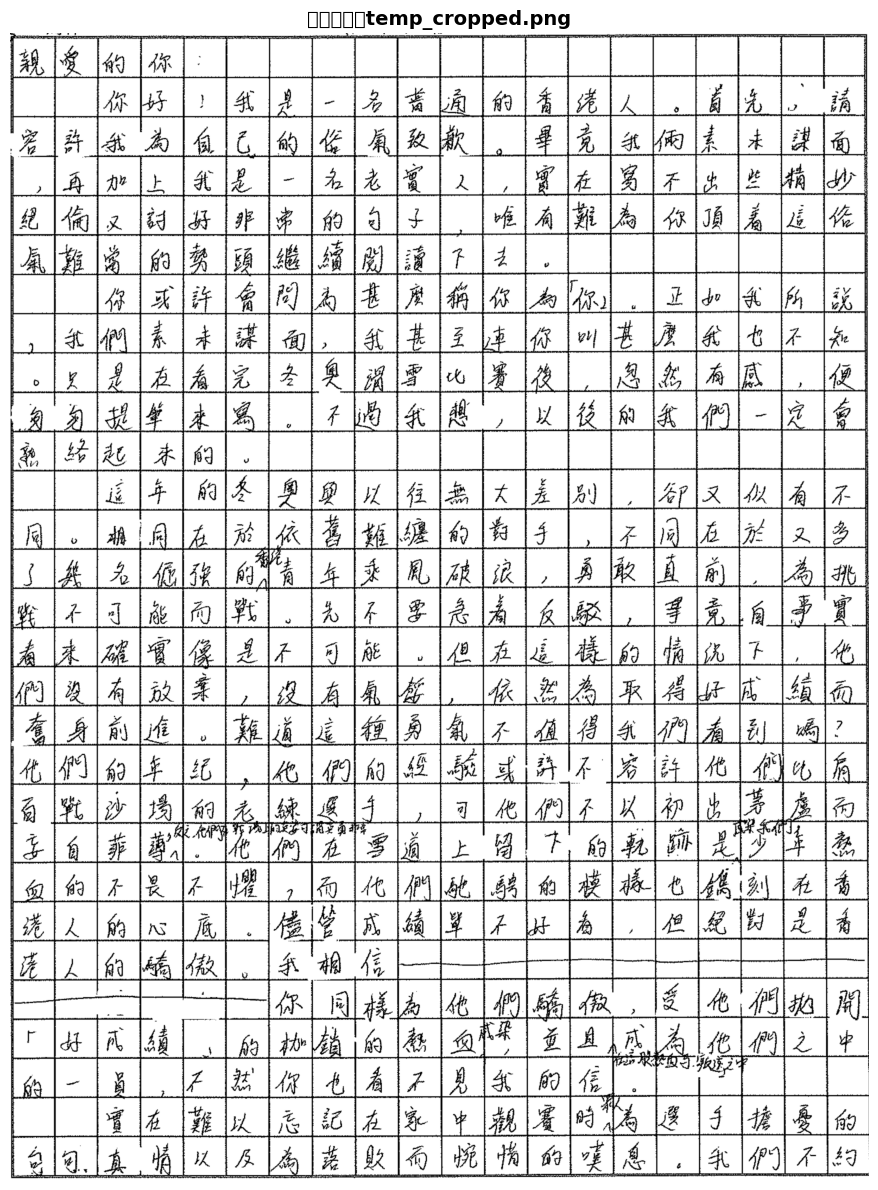

In [4]:
# 加载裁剪后的测试图片
img_path = project_root / 'output' / 'temp_cropped.png'
img = cv2.imread(str(img_path))
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

print(f"图片路径: {img_path}")
print(f"图片尺寸: {img.shape[:2]} (H×W)")
print(f"是否存在: {img_path.exists()}")

# 显示原图
plt.figure(figsize=(10, 12))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('测试图片：temp_cropped.png', fontsize=14, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

In [5]:
# 加载 Ground Truth
gt_file = project_root / 'data' / 'samples' / '2022 第2題 (冬奧) (8份)_Original' / 'sample_01_01_ground_truth.txt'
with open(gt_file, 'r', encoding='utf-8') as f:
    ground_truth = f.read()

# 清理 ground truth
gt_clean = re.sub(r'<insert>|</insert>|<\?>', '', ground_truth)
gt_clean = gt_clean.replace('\n', '').replace(' ', '')

print(f"Ground Truth 字符数: {len(gt_clean)}")
print(f"Ground Truth 前100字符:\n{gt_clean[:100]}")
print("="*60)

Ground Truth 字符数: 552
Ground Truth 前100字符:
親愛的你：你好！我是一名普通的香港人。首先，請容許我爲自己的俗氣致歉。畢竟我倆素未謀面，再加上我是一名老實人，實在寫不出些精妙絕倫又討好非常的句子，唯有難爲你頂著這俗氣難當的石頭繼續閲讀下去。你或許會


## 3. 检测横线和竖线

In [6]:
# 检测横线和竖线
lines = detect_grid_lines(
    img_gray,
    detect_horizontal=True,
    detect_vertical=True,
    min_length=200,
    threshold=100,
    angle_range_horizontal=(0, 5),
    angle_range_vertical=(85, 95)
)

horizontal_lines = lines['horizontal']
vertical_lines = lines['vertical']

print(f"检测到横线数: {len(horizontal_lines)}")
print(f"检测到竖线数: {len(vertical_lines)}")
print("="*60)

检测到横线数: 259
检测到竖线数: 190


C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\1647036196.py:17: UserWarning: Glyph 26816 (\N{CJK UNIFIED IDEOGRAPH-68C0}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\1647036196.py:17: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\1647036196.py:17: UserWarning: Glyph 21040 (\N{CJK UNIFIED IDEOGRAPH-5230}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\1647036196.py:17: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\1647036196.py:17: UserWarning: Glyph 27178 (\N{CJK UNIFIED IDEOGRAPH-6A2A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\1647036196.py:17: UserWarning: Gl

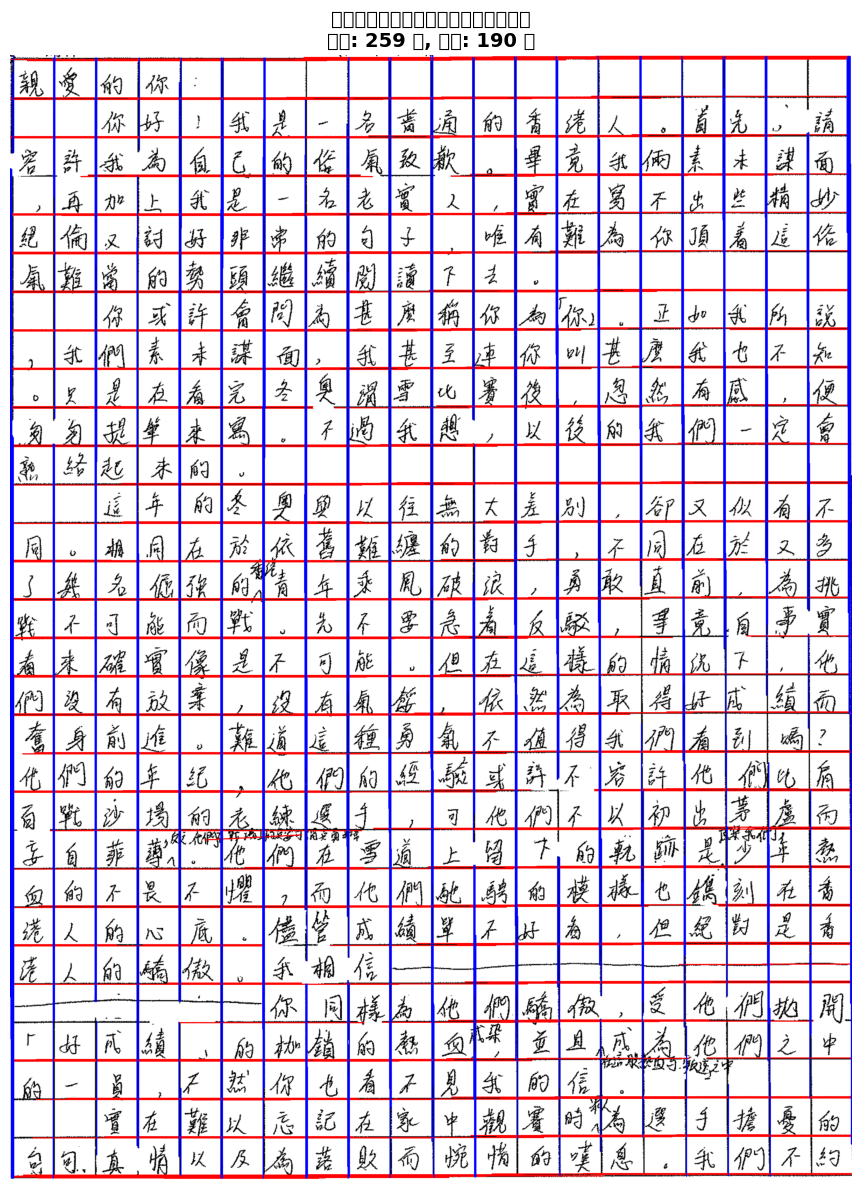

In [7]:
# 可视化检测到的横线和竖线
img_lines = img.copy()

# 画横线（红色）
for x1, y1, x2, y2, angle in horizontal_lines:
    cv2.line(img_lines, (x1, y1), (x2, y2), (0, 0, 255), 2)

# 画竖线（蓝色）
for x, y1, y2, angle in vertical_lines:
    cv2.line(img_lines, (x, y1), (x, y2), (255, 0, 0), 2)

plt.figure(figsize=(10, 12))
plt.imshow(cv2.cvtColor(img_lines, cv2.COLOR_BGR2RGB))
plt.title(f'检测到的横线（红色）和竖线（蓝色）\n横线: {len(horizontal_lines)} 条, 竖线: {len(vertical_lines)} 条', 
          fontsize=14, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

## 4. 生成格子网格

In [8]:
# 生成格子网格
cells = generate_grid_cells(
    horizontal_lines,
    vertical_lines,
    img.shape,
    merge_threshold=10
)

print(f"生成格子数: {len(cells)}")
if cells:
    print(f"第一个格子: row={cells[0]['row']}, col={cells[0]['col']}, "
          f"位置=({cells[0]['x1']}, {cells[0]['y1']}, {cells[0]['x2']}, {cells[0]['y2']})")
print("="*60)

生成格子数: 609
第一个格子: row=0, col=0, 位置=(5, 8, 113, 110)


## 5. 可视化格子网格

C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\2180256180.py:8: UserWarning: Glyph 26684 (\N{CJK UNIFIED IDEOGRAPH-683C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\2180256180.py:8: UserWarning: Glyph 23376 (\N{CJK UNIFIED IDEOGRAPH-5B50}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\2180256180.py:8: UserWarning: Glyph 32593 (\N{CJK UNIFIED IDEOGRAPH-7F51}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\2180256180.py:8: UserWarning: Glyph 21487 (\N{CJK UNIFIED IDEOGRAPH-53EF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\2180256180.py:8: UserWarning: Glyph 35270 (\N{CJK UNIFIED IDEOGRAPH-89C6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\2180256180.py:8: UserWarning: Glyph 21

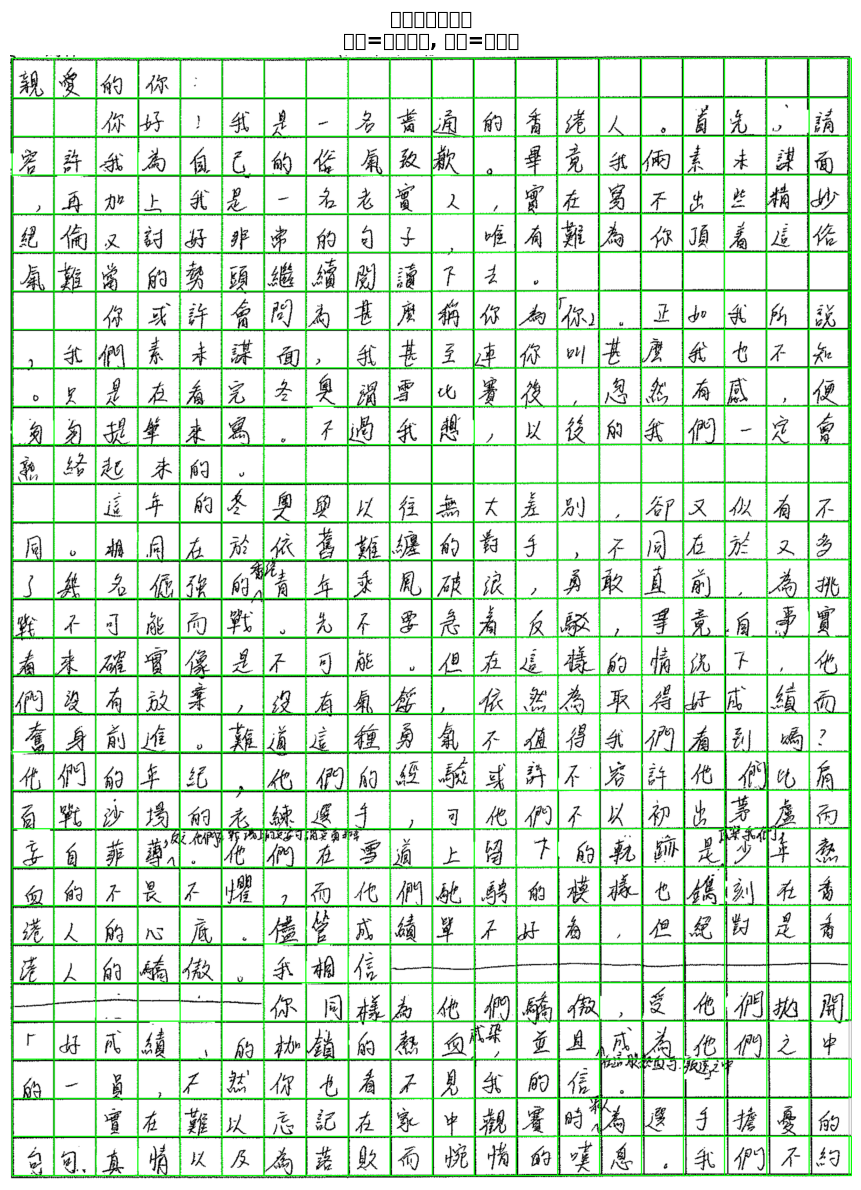

In [9]:
# 可视化格子（区分空/非空）
img_grid = visualize_grid(img, cells, show_empty=True)

plt.figure(figsize=(10, 12))
plt.imshow(cv2.cvtColor(img_grid, cv2.COLOR_BGR2RGB))
plt.title('格子网格可视化\n绿色=非空格子, 灰色=空格子', fontsize=14, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

## 6. 格子统计信息

In [11]:
# 获取格子统计信息
stats = get_grid_statistics(img, cells)

print("="*60)
print("格子统计信息")
print("="*60)
print(f"总格子数: {stats['total_cells']}")
print(f"空格子数: {stats['empty_cells']}")
print(f"非空格子数: {stats['filled_cells']}")
print(f"行数: {stats['num_rows']}")
print(f"列数: {stats['num_cols']}")
print(f"平均格子宽度: {stats['avg_cell_width']:.1f} ± {stats['std_cell_width']:.1f} px")
print(f"平均格子高度: {stats['avg_cell_height']:.1f} ± {stats['std_cell_height']:.1f} px")
print("="*60)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

## 7. 裁剪非空格子

非空格子数: 607
预期字符数（Ground Truth）: 552


C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\244076449.py:25: UserWarning: Glyph 26684 (\N{CJK UNIFIED IDEOGRAPH-683C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\244076449.py:25: UserWarning: Glyph 23376 (\N{CJK UNIFIED IDEOGRAPH-5B50}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\244076449.py:25: UserWarning: Glyph 21069 (\N{CJK UNIFIED IDEOGRAPH-524D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\244076449.py:25: UserWarning: Glyph 20010 (\N{CJK UNIFIED IDEOGRAPH-4E2A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\244076449.py:25: UserWarning: Glyph 38750 (\N{CJK UNIFIED IDEOGRAPH-975E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\244076449.py:25: UserWarning: Glyph 31

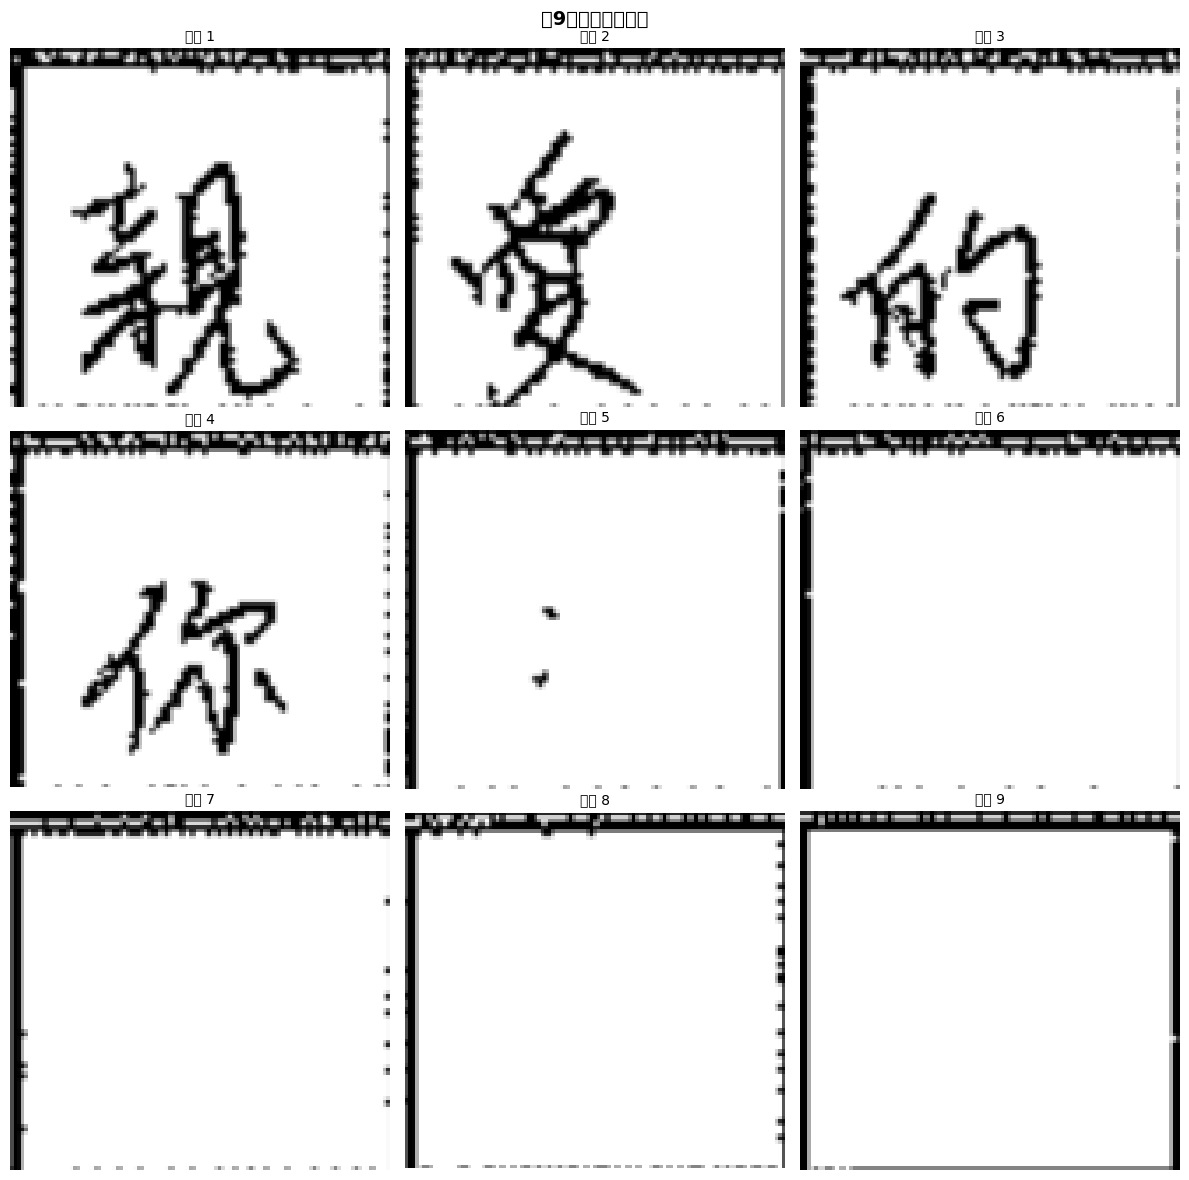

In [12]:
# 过滤非空格子并裁剪
non_empty_cells = []
cell_images = []

for cell in cells:
    x1, y1, x2, y2 = cell['x1'], cell['y1'], cell['x2'], cell['y2']
    cell_img = img[y1:y2, x1:x2]
    
    if not is_cell_empty(cell_img):
        non_empty_cells.append(cell)
        cell_images.append(cell_img)

print(f"非空格子数: {len(non_empty_cells)}")
print(f"预期字符数（Ground Truth）: {len(gt_clean)}")
print("="*60)

# 显示前9个格子样例
if len(cell_images) >= 9:
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    for i, (ax, cell_img) in enumerate(zip(axes.flat, cell_images[:9])):
        ax.imshow(cv2.cvtColor(cell_img, cv2.COLOR_BGR2RGB))
        ax.set_title(f"格子 {i+1}", fontsize=10)
        ax.axis('off')
    plt.suptitle('前9个非空格子样例', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

## 8. 单字识别（PaddleOCR rec 模式）

In [19]:
# 初始化 TextRecognition（仅识别模式）
from paddleocr import TextRecognition

print("初始化 TextRecognition（仅识别模式）...")
text_rec = TextRecognition()
print("✓ TextRecognition 初始化完成")

Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\Quenton\.paddlex\official_models\PP-OCRv5_server_rec`.


初始化 TextRecognition（仅识别模式）...
✓ TextRecognition 初始化完成
✓ TextRecognition 初始化完成


In [21]:
# 对每个非空格子进行单字识别
recognition_results = []

print("\n开始识别...")
print("="*60)

for i, (cell, cell_img) in enumerate(zip(non_empty_cells, cell_images)):
    # 保存格子图片到临时文件（TextRecognition 需要文件路径）
    temp_cell_path = project_root / 'output' / f'temp_cell_{i}.png'
    cv2.imwrite(str(temp_cell_path), cell_img)
    
    # 使用 TextRecognition 识别
    result = text_rec.predict(str(temp_cell_path))
    
    if result and len(result) > 0:
        res_dict = result[0]  # 获取结果字典
        text = res_dict.get('rec_text', '')
        confidence = res_dict.get('rec_score', 0.0)
    else:
        text = ''
        confidence = 0.0
    
    recognition_results.append({
        'row': cell['row'],
        'col': cell['col'],
        'text': text,
        'confidence': confidence,
        'position': (cell['x1'], cell['y1'], cell['x2'], cell['y2'])
    })
    
    # 删除临时文件
    temp_cell_path.unlink()
    
    if (i + 1) % 50 == 0:
        print(f"已识别 {i+1}/{len(non_empty_cells)} 个格子...")

print(f"\n✓ 识别完成，共识别 {len(recognition_results)} 个格子")
print("="*60)


开始识别...
已识别 50/607 个格子...
已识别 50/607 个格子...
已识别 100/607 个格子...
已识别 100/607 个格子...
已识别 150/607 个格子...
已识别 150/607 个格子...
已识别 200/607 个格子...
已识别 200/607 个格子...
已识别 250/607 个格子...
已识别 250/607 个格子...
已识别 300/607 个格子...
已识别 300/607 个格子...
已识别 350/607 个格子...
已识别 350/607 个格子...
已识别 400/607 个格子...
已识别 400/607 个格子...
已识别 450/607 个格子...
已识别 450/607 个格子...
已识别 500/607 个格子...
已识别 500/607 个格子...
已识别 550/607 个格子...
已识别 550/607 个格子...
已识别 600/607 个格子...

✓ 识别完成，共识别 607 个格子
已识别 600/607 个格子...

✓ 识别完成，共识别 607 个格子


In [22]:
# 显示识别结果样例
print("前20个识别结果:")
print("="*60)
for i, result in enumerate(recognition_results[:20]):
    print(f"{i+1:3d}. Row={result['row']:2d}, Col={result['col']:2d} | "
          f"'{result['text']}' (置信度: {result['confidence']:.3f})")
print("="*60)

前20个识别结果:
  1. Row= 0, Col= 0 | '親' (置信度: 0.966)
  2. Row= 0, Col= 1 | '爱' (置信度: 0.860)
  3. Row= 0, Col= 2 | '的' (置信度: 0.995)
  4. Row= 0, Col= 3 | '你' (置信度: 0.989)
  5. Row= 0, Col= 4 | '.co' (置信度: 0.496)
  6. Row= 0, Col= 5 | '' (置信度: 0.000)
  7. Row= 0, Col= 6 | '' (置信度: 0.000)
  8. Row= 0, Col= 7 | '' (置信度: 0.000)
  9. Row= 0, Col= 8 | '二' (置信度: 0.193)
 10. Row= 0, Col= 9 | '二' (置信度: 0.110)
 11. Row= 0, Col=10 | '二' (置信度: 0.108)
 12. Row= 0, Col=11 | '二' (置信度: 0.169)
 13. Row= 0, Col=12 | '' (置信度: 0.000)
 14. Row= 0, Col=13 | '' (置信度: 0.000)
 15. Row= 0, Col=14 | '-' (置信度: 0.134)
 16. Row= 0, Col=15 | '7' (置信度: 0.092)
 17. Row= 0, Col=16 | '-' (置信度: 0.225)
 18. Row= 0, Col=17 | '国' (置信度: 0.121)
 19. Row= 0, Col=18 | '' (置信度: 0.000)
 20. Row= 0, Col=19 | '-' (置信度: 0.120)


## 9. 按序拼接结果

In [23]:
# 按行列顺序排序并拼接
recognition_results.sort(key=lambda x: (x['row'], x['col']))

# 拼接识别文本
recognized_text = ''.join([result['text'] for result in recognition_results])

print(f"识别字符数: {len(recognized_text)}")
print(f"Ground Truth 字符数: {len(gt_clean)}")
print(f"\n识别文本前200字符:")
print(recognized_text[:200])
print("\n" + "="*60)

识别字符数: 529
Ground Truth 字符数: 552

识别文本前200字符:
親爱的你.co二二二二-7-国-你好1我是名普通的香港人。首先。請容許我為自己的俗氣致歉一畢竞我俩素未谋面再加上我是-名老實人寶在易不出些精妙纪倫又討好非常的句子唯有難為你顶着這俗氣難當的势頭繼續閱讀下去。国-国西你或許會問高甚魔稱你為你正如我所说,我們素未謀面,我甚至連你叫甚麽我也不知。只是在看完冬奥滑雪比賽後忽然有感便匆勿提筆來寫。不過我想,以後的我们日定會熟络起未的。广三--國這年的冬奥奥以



## 9.2 可视化识别结果（对比图）

类似 PaddleOCR 的输出，左边显示原图，右边显示按位置拼接的识别文本。

生成识别结果可视化...


C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\3518806100.py:94: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\3518806100.py:94: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\3518806100.py:94: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\3518806100.py:94: UserWarning: Glyph 20687 (\N{CJK UNIFIED IDEOGRAPH-50CF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\3518806100.py:94: UserWarning: Glyph 35782 (\N{CJK UNIFIED IDEOGRAPH-8BC6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\3518806100.py:94: UserWarning: Gl

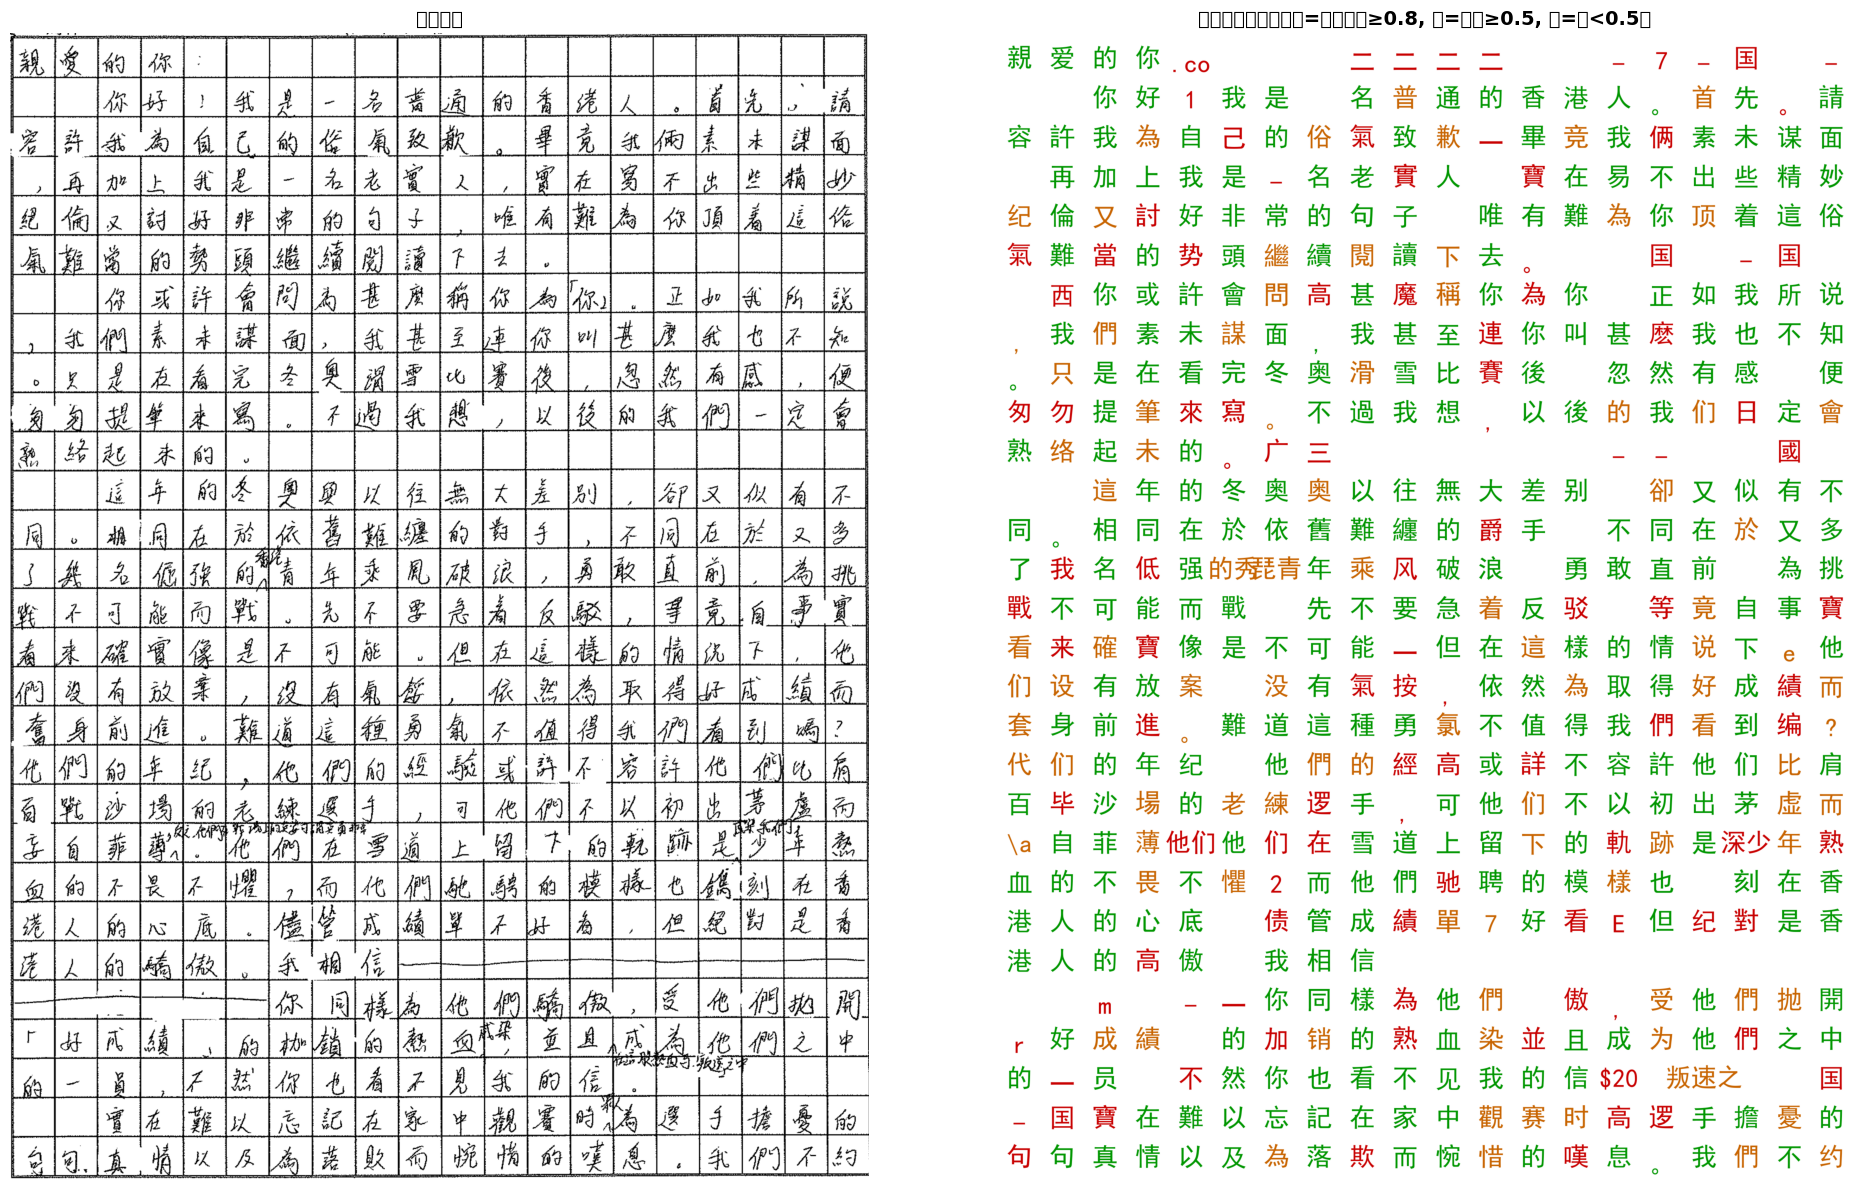

✓ 可视化完成


In [42]:
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

def visualize_ocr_results(image, recognition_results, font_path=None, font_size=20):
    """
    可视化 OCR 识别结果，左边原图，右边按位置绘制识别文本
    
    Args:
        image: 原始图像 (numpy array)
        recognition_results: 识别结果列表，每个元素包含 text, confidence, position
        font_path: 字体文件路径
        font_size: 字体大小
    """
    # 转换为 PIL Image
    if isinstance(image, np.ndarray):
        img_pil = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    else:
        img_pil = image
    
    # 创建右侧文本图像
    img_text = Image.new('RGB', img_pil.size, (255, 255, 255))
    draw = ImageDraw.Draw(img_text)
    
    # 尝试加载中文字体
    try:
        if font_path and Path(font_path).exists():
            font = ImageFont.truetype(font_path, font_size)
        else:
            # 尝试系统默认中文字体
            font_paths = [
                'C:/Windows/Fonts/simhei.ttf',  # 黑体
                'C:/Windows/Fonts/msyh.ttc',    # 微软雅黑
                'C:/Windows/Fonts/simsun.ttc',  # 宋体
            ]
            font = None
            for fp in font_paths:
                if Path(fp).exists():
                    font = ImageFont.truetype(fp, font_size)
                    break
            if font is None:
                font = ImageFont.load_default()
                print("⚠️ 未找到中文字体，使用默认字体")
    except Exception as e:
        font = ImageFont.load_default()
        print(f"⚠️ 字体加载失败: {e}，使用默认字体")
    
    # 在右侧图像上按位置绘制文本
    for result in recognition_results:
        text = result['text']
        confidence = result['confidence']
        x1, y1, x2, y2 = result['position']
        
        # 计算文本位置（格子中心）
        center_x = (x1 + x2) // 2
        center_y = (y1 + y2) // 2
        
        # 根据置信度选择颜色
        if confidence >= 0.8:
            color = (0, 150, 0)  # 深绿色 - 高置信度
        elif confidence >= 0.5:
            color = (200, 100, 0)  # 橙色 - 中等置信度
        else:
            color = (200, 0, 0)  # 红色 - 低置信度
        
        # 绘制文本
        try:
            # 计算文本边界框以居中显示
            bbox = draw.textbbox((0, 0), text, font=font)
            text_width = bbox[2] - bbox[0]
            text_height = bbox[3] - bbox[1]
            
            text_x = center_x - text_width // 2
            text_y = center_y - text_height // 2
            
            draw.text((text_x, text_y), text, fill=color, font=font)
        except Exception as e:
            # 如果文本绘制失败，使用简单方式
            draw.text((center_x, center_y), text, fill=color, font=font)
    
    # 并排显示
    fig, axes = plt.subplots(1, 2, figsize=(20, 12))
    
    # 左侧：原图
    axes[0].imshow(img_pil)
    axes[0].set_title('原始图像', fontsize=14, fontweight='bold')
    axes[0].axis('off')
    
    # 右侧：识别结果
    axes[1].imshow(img_text)
    axes[1].set_title('识别结果（颜色：绿=高置信度≥0.8, 橙=中等≥0.5, 红=低<0.5）', 
                     fontsize=14, fontweight='bold')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return img_text

# 生成可视化对比图
print("生成识别结果可视化...")
result_image = visualize_ocr_results(img, recognition_results, font_size=65)
print("✓ 可视化完成")

In [43]:
# 详细统计分析
print("\n" + "="*80)
print("识别结果详细统计")
print("="*80)

# 置信度分布统计
confidences = [r['confidence'] for r in recognition_results]
high_conf = sum(1 for c in confidences if c >= 0.8)
mid_conf = sum(1 for c in confidences if 0.5 <= c < 0.8)
low_conf = sum(1 for c in confidences if c < 0.5)

print(f"\n置信度分布:")
print(f"  高置信度 (≥0.8): {high_conf} 个 ({high_conf/len(confidences)*100:.1f}%)")
print(f"  中等置信度 (0.5-0.8): {mid_conf} 个 ({mid_conf/len(confidences)*100:.1f}%)")
print(f"  低置信度 (<0.5): {low_conf} 个 ({low_conf/len(confidences)*100:.1f}%)")
print(f"  平均置信度: {np.mean(confidences):.3f}")

# 文本长度统计
text_lengths = [len(r['text']) for r in recognition_results]
multi_char = sum(1 for length in text_lengths if length > 1)
single_char = sum(1 for length in text_lengths if length == 1)
empty_char = sum(1 for length in text_lengths if length == 0)

print(f"\n识别文本长度分布:")
print(f"  单字符: {single_char} 个 ({single_char/len(text_lengths)*100:.1f}%)")
print(f"  多字符: {multi_char} 个 ({multi_char/len(text_lengths)*100:.1f}%)")
print(f"  空文本: {empty_char} 个 ({empty_char/len(text_lengths)*100:.1f}%)")

# 显示一些问题样例
print(f"\n问题样例分析:")
print("-" * 80)

# 1. 低置信度样例
low_conf_samples = [(r['text'], r['confidence']) for r in recognition_results if r['confidence'] < 0.5]
if low_conf_samples:
    print(f"\n【低置信度样例】(置信度 < 0.5)，共 {len(low_conf_samples)} 个:")
    for i, (text, conf) in enumerate(low_conf_samples[:10]):
        print(f"  {i+1:2d}. '{text}' (置信度: {conf:.3f})")

# 2. 多字符识别样例
multi_char_samples = [(r['text'], r['confidence']) for r in recognition_results if len(r['text']) > 1]
if multi_char_samples:
    print(f"\n【多字符识别样例】（应该是单字），共 {len(multi_char_samples)} 个:")
    for i, (text, conf) in enumerate(multi_char_samples[:10]):
        print(f"  {i+1:2d}. '{text}' (置信度: {conf:.3f})")

# 3. 空文本样例
empty_samples = [r for r in recognition_results if len(r['text']) == 0]
if empty_samples:
    print(f"\n【空文本样例】（识别失败），共 {len(empty_samples)} 个")

print("\n" + "="*80)


识别结果详细统计

置信度分布:
  高置信度 (≥0.8): 318 个 (52.4%)
  中等置信度 (0.5-0.8): 92 个 (15.2%)
  低置信度 (<0.5): 197 个 (32.5%)
  平均置信度: 0.657

识别文本长度分布:
  单字符: 510 个 (84.0%)
  多字符: 8 个 (1.3%)
  空文本: 89 个 (14.7%)

问题样例分析:
--------------------------------------------------------------------------------

【低置信度样例】(置信度 < 0.5)，共 197 个:
   1. '.co' (置信度: 0.496)
   2. '' (置信度: 0.000)
   3. '' (置信度: 0.000)
   4. '' (置信度: 0.000)
   5. '二' (置信度: 0.193)
   6. '二' (置信度: 0.110)
   7. '二' (置信度: 0.108)
   8. '二' (置信度: 0.169)
   9. '' (置信度: 0.000)
  10. '' (置信度: 0.000)

【多字符识别样例】（应该是单字），共 8 个:
   1. '.co' (置信度: 0.496)
   2. '的秀' (置信度: 0.697)
   3. '琵青' (置信度: 0.758)
   4. '\a' (置信度: 0.504)
   5. '他们' (置信度: 0.307)
   6. '深少' (置信度: 0.319)
   7. '$20' (置信度: 0.403)
   8. '叛速之' (置信度: 0.619)

【空文本样例】（识别失败），共 89 个



In [44]:
# 保存可视化结果到文件
output_dir = project_root / 'output'
output_dir.mkdir(exist_ok=True)

# 保存对比图
comparison_path = output_dir / 'grid_ocr_comparison.png'
fig, axes = plt.subplots(1, 2, figsize=(20, 12))

# 左侧：原图
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
axes[0].imshow(img_rgb)
axes[0].set_title('原始图像', fontsize=14, fontweight='bold')
axes[0].axis('off')

# 右侧：识别结果
axes[1].imshow(result_image)
axes[1].set_title('识别结果（颜色：绿=高置信度≥0.8, 橙=中等≥0.5, 红=低<0.5）', 
                 fontsize=65, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.savefig(comparison_path, dpi=150, bbox_inches='tight')
plt.close()

print(f"✓ 对比图已保存到: {comparison_path}")

# 保存识别结果到 JSON
results_json_path = output_dir / 'grid_ocr_results.json'
results_data = {
    'total_cells': len(recognition_results),
    'recognized_text': recognized_text,
    'statistics': {
        'avg_confidence': float(np.mean(confidences)),
        'high_confidence_count': high_conf,
        'mid_confidence_count': mid_conf,
        'low_confidence_count': low_conf,
        'single_char_count': single_char,
        'multi_char_count': multi_char,
        'empty_count': empty_char
    },
    'results': [
        {
            'row': r['row'],
            'col': r['col'],
            'text': r['text'],
            'confidence': float(r['confidence']),
            'position': r['position']
        }
        for r in recognition_results
    ]
}

with open(results_json_path, 'w', encoding='utf-8') as f:
    json.dump(results_data, f, ensure_ascii=False, indent=2)

print(f"✓ 识别结果已保存到: {results_json_path}")

C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\4281470443.py:21: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\4281470443.py:21: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\4281470443.py:21: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\4281470443.py:21: UserWarning: Glyph 20687 (\N{CJK UNIFIED IDEOGRAPH-50CF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\4281470443.py:21: UserWarning: Glyph 35782 (\N{CJK UNIFIED IDEOGRAPH-8BC6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\4281470443.py:21: UserWarning: Gl

✓ 对比图已保存到: c:\Users\Quenton\Documents\Github\writtingOCR\output\grid_ocr_comparison.png
✓ 识别结果已保存到: c:\Users\Quenton\Documents\Github\writtingOCR\output\grid_ocr_results.json


## 9.5 置信度过滤方案

尝试移除置信度低于 0.5 的字符，看是否能提升准确率。

In [46]:
# 过滤置信度低于 0.3 的字符
confidence_threshold = 0.3

# 统计置信度分布
confidences = [r['confidence'] for r in recognition_results]
low_conf_count = sum(1 for c in confidences if c < confidence_threshold)

print("="*60)
print("置信度分布分析")
print("="*60)
print(f"总字符数: {len(confidences)}")
print(f"低置信度字符数 (< {confidence_threshold}): {low_conf_count} ({low_conf_count/len(confidences)*100:.1f}%)")
print(f"平均置信度: {np.mean(confidences):.3f}")
print(f"最低置信度: {np.min(confidences):.3f}")
print(f"最高置信度: {np.max(confidences):.3f}")
print("="*60)

# 显示一些低置信度的例子
low_conf_samples = [(r['text'], r['confidence']) for r in recognition_results if r['confidence'] < confidence_threshold]
if low_conf_samples:
    print(f"\n低置信度字符样例（前20个）:")
    for i, (text, conf) in enumerate(low_conf_samples[:20]):
        print(f"  {i+1:2d}. '{text}' (置信度: {conf:.3f})")
    print("="*60)

置信度分布分析
总字符数: 607
低置信度字符数 (< 0.3): 141 (23.2%)
平均置信度: 0.657
最低置信度: 0.000
最高置信度: 1.000

低置信度字符样例（前20个）:
   1. '' (置信度: 0.000)
   2. '' (置信度: 0.000)
   3. '' (置信度: 0.000)
   4. '二' (置信度: 0.193)
   5. '二' (置信度: 0.110)
   6. '二' (置信度: 0.108)
   7. '二' (置信度: 0.169)
   8. '' (置信度: 0.000)
   9. '' (置信度: 0.000)
  10. '-' (置信度: 0.134)
  11. '7' (置信度: 0.092)
  12. '-' (置信度: 0.225)
  13. '国' (置信度: 0.121)
  14. '' (置信度: 0.000)
  15. '-' (置信度: 0.120)
  16. '' (置信度: 0.000)
  17. '' (置信度: 0.000)
  18. '' (置信度: 0.000)
  19. '' (置信度: 0.000)
  20. '。' (置信度: 0.105)


In [47]:
# 过滤并拼接文本（移除低置信度字符）
filtered_results = [r for r in recognition_results if r['confidence'] >= confidence_threshold]
filtered_text = ''.join([r['text'] for r in filtered_results])

print("\n过滤后拼接结果:")
print("="*60)
print(f"过滤前字符数: {len(recognized_text)}")
print(f"过滤后字符数: {len(filtered_text)}")
print(f"移除字符数: {len(recognized_text) - len(filtered_text)}")
print(f"\n过滤后文本前200字符:")
print(filtered_text[:200])
print("="*60)


过滤后拼接结果:
过滤前字符数: 529
过滤后字符数: 477
移除字符数: 52

过滤后文本前200字符:
親爱的你.co你好1我是名普通的香港人。首先請容許我為自己的俗氣致歉畢竞我俩素未谋面再加上我是-名老人寶在易不出些精妙纪倫又好非常的句子唯有難為你顶着這俗氣難當的势頭繼續閱讀下去你或許會問甚稱你你正如我所说,我們素未謀面,我甚至連你叫甚我也不知。只是在看完冬奥滑雪比賽後忽然有感便匆勿提筆來寫。不過我想,以後的我们定會熟络起未的。广這年的冬奥奥以往無大差别卻又似有不同。相同在於依舊難纏的爵手不同在於


In [48]:
# 计算过滤后的准确率
metrics_filtered = calculate_accuracy(filtered_text, gt_clean)

print("\n置信度过滤方案 - 准确率评估")
print("="*80)
print(f"Ground Truth 字符数: {metrics_filtered['total_chars']}")
print(f"识别字符数: {len(filtered_text)}")
print(f"匹配字符数: {metrics_filtered['matched_chars']}")
print(f"准确率: {metrics_filtered['accuracy']:.2f}%")
print(f"相似度: {metrics_filtered['similarity']:.2f}%")
print("="*80)

# 对比未过滤版本
print("\n对比分析（过滤 vs 未过滤）:")
print("="*80)
print(f"未过滤准确率: {metrics['accuracy']:.2f}%")
print(f"过滤后准确率: {metrics_filtered['accuracy']:.2f}%")
print(f"准确率变化: {metrics_filtered['accuracy'] - metrics['accuracy']:+.2f}%")
print("="*80)


置信度过滤方案 - 准确率评估
Ground Truth 字符数: 552
识别字符数: 477
匹配字符数: 360
准确率: 65.22%
相似度: 69.97%

对比分析（过滤 vs 未过滤）:
未过滤准确率: 66.85%
过滤后准确率: 65.22%
准确率变化: -1.63%


## 10. 准确率评估

In [49]:
# 计算准确率
def calculate_accuracy(predicted_text, ground_truth_text):
    """计算字符级准确率"""
    pred_clean = predicted_text.replace('\n', '').replace(' ', '')
    gt_clean = ground_truth_text.replace('\n', '').replace(' ', '')
    
    matcher = difflib.SequenceMatcher(None, pred_clean, gt_clean)
    similarity = matcher.ratio()
    
    total_chars = len(gt_clean)
    matches = sum(block.size for block in matcher.get_matching_blocks())
    
    return {
        'similarity': similarity * 100,
        'total_chars': total_chars,
        'matched_chars': matches,
        'accuracy': (matches / total_chars * 100) if total_chars > 0 else 0
    }

metrics = calculate_accuracy(recognized_text, gt_clean)

print("="*80)
print("格子分割方案 - 准确率评估")
print("="*80)
print(f"Ground Truth 字符数: {metrics['total_chars']}")
print(f"识别字符数: {len(recognized_text)}")
print(f"匹配字符数: {metrics['matched_chars']}")
print(f"准确率: {metrics['accuracy']:.2f}%")
print(f"相似度: {metrics['similarity']:.2f}%")
print("="*80)

格子分割方案 - 准确率评估
Ground Truth 字符数: 552
识别字符数: 529
匹配字符数: 369
准确率: 66.85%
相似度: 68.27%


## 11. 对比分析（vs 竖线删除方案）

方案对比
原图（有竖线）                       :  53.62%
v3_width9（删除竖线）               :  65.76%
格子分割方案                        :  66.85%
格子分割+置信度过滤                    :  65.22%

改善分析:
格子分割方案:
  vs 原图: +13.23%
  vs v3_width9: +1.09%

格子分割+置信度过滤:
  vs 原图: +11.60%
  vs v3_width9: -0.54%
  vs 格子分割（未过滤）: -1.63%


C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\1893312784.py:52: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\1893312784.py:52: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\1893312784.py:52: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\1893312784.py:52: UserWarning: Glyph 26377 (\N{CJK UNIFIED IDEOGRAPH-6709}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\1893312784.py:52: UserWarning: Glyph 31446 (\N{CJK UNIFIED IDEOGRAPH-7AD6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\1893312784.py:52: UserWarning: Gl

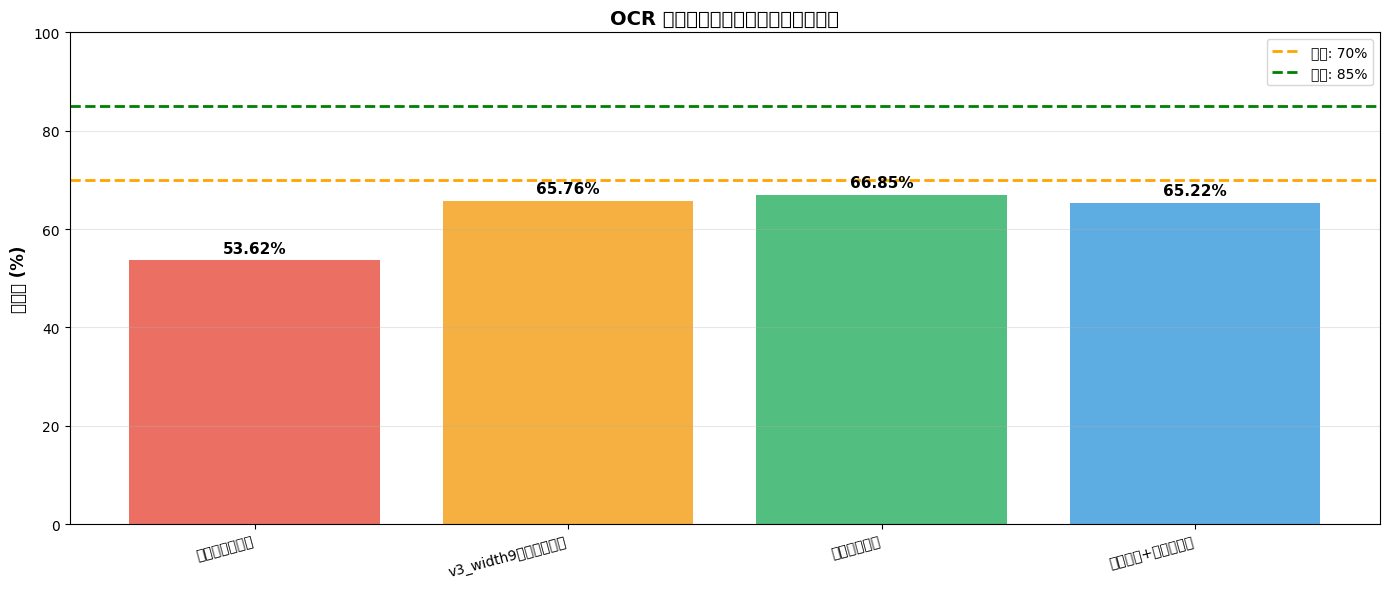

In [50]:
# 对比不同方案的准确率
comparison_data = {
    '原图（有竖线）': 53.62,
    'v3_width9（删除竖线）': 65.76,
    '格子分割方案': metrics['accuracy'],
    '格子分割+置信度过滤': metrics_filtered['accuracy']
}

print("="*80)
print("方案对比")
print("="*80)
for method, accuracy in comparison_data.items():
    print(f"{method:30s}: {accuracy:6.2f}%")

print("\n改善分析:")
improvement_vs_original = metrics['accuracy'] - comparison_data['原图（有竖线）']
improvement_vs_v3 = metrics['accuracy'] - comparison_data['v3_width9（删除竖线）']
improvement_filtered_vs_original = metrics_filtered['accuracy'] - comparison_data['原图（有竖线）']
improvement_filtered_vs_v3 = metrics_filtered['accuracy'] - comparison_data['v3_width9（删除竖线）']
improvement_filtered_vs_unfiltered = metrics_filtered['accuracy'] - metrics['accuracy']

print(f"格子分割方案:")
print(f"  vs 原图: {improvement_vs_original:+.2f}%")
print(f"  vs v3_width9: {improvement_vs_v3:+.2f}%")
print(f"\n格子分割+置信度过滤:")
print(f"  vs 原图: {improvement_filtered_vs_original:+.2f}%")
print(f"  vs v3_width9: {improvement_filtered_vs_v3:+.2f}%")
print(f"  vs 格子分割（未过滤）: {improvement_filtered_vs_unfiltered:+.2f}%")

# 可视化对比
fig, ax = plt.subplots(figsize=(14, 6))
methods = list(comparison_data.keys())
accuracies = list(comparison_data.values())
colors = ['#e74c3c', '#f39c12', '#27ae60', '#3498db']

bars = ax.bar(methods, accuracies, color=colors, alpha=0.8)
ax.set_ylabel('准确率 (%)', fontsize=12, fontweight='bold')
ax.set_title('OCR 方案准确率对比（含置信度过滤）', fontsize=14, fontweight='bold')
ax.set_ylim(0, 100)
ax.axhline(y=70, color='orange', linestyle='--', linewidth=2, label='目标: 70%')
ax.axhline(y=85, color='green', linestyle='--', linewidth=2, label='理想: 85%')
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3)

# 标注数值
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{acc:.2f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()

print("="*80)

## 12. 实验结论和下一步计划

In [52]:
# 实验结论
print("="*80)
print("实验结论")
print("="*80)

current_accuracy = metrics['accuracy']

if current_accuracy >= 85:
    print("\n🎉 实验大成功！")
    print(f"  - 格子分割方案准确率: {current_accuracy:.2f}%")
    print(f"  - 已达到 Stage 1 目标（85%）")
    print(f"  - 相比 v3_width9 提升: {improvement_vs_v3:+.2f}%")
    print("\n下一步计划:")
    print("  1. 应用到全部 48 张图片")
    print("  2. 进入 Stage 2：删除线检测和评分标准提取")
    
elif current_accuracy >= 70:
    print("\n✅ 实验成功！")
    print(f"  - 格子分割方案准确率: {current_accuracy:.2f}%")
    print(f"  - 已突破 70% 目标")
    print(f"  - 相比 v3_width9 提升: {improvement_vs_v3:+.2f}%")
    print("\n下一步计划:")
    print("  1. 分析错误原因，优化格子检测参数")
    print("  2. 考虑微调识别模型或使用 TrOCR")
    print("  3. 目标：提升到 85%")
    
elif current_accuracy > comparison_data['v3_width9（删除竖线）']:
    print("\n⚠️ 实验部分成功")
    print(f"  - 格子分割方案准确率: {current_accuracy:.2f}%")
    print(f"  - 相比 v3_width9 提升: {improvement_vs_v3:+.2f}%")
    print(f"  - 但未达到 70% 目标（还差 {70 - current_accuracy:.2f}%）")
    print("\n下一步计划:")
    print("  1. 详细分析错误类型（格子检测？单字识别？）")
    print("  2. 尝试替换 rec 模型（TrOCR、手写字符专用模型）")
    print("  3. 优化格子检测参数（threshold、min_length）")
    
else:
    print("\n❌ 实验未达预期")
    print(f"  - 格子分割方案准确率: {current_accuracy:.2f}%")
    print(f"  - 比 v3_width9 更差: {improvement_vs_v3:.2f}%")
    print("\n失败原因分析:")
    print("  可能问题：")
    print("  - 格子检测不准确（横竖线漏检）")
    print("  - 单字识别模型不适合（PaddleOCR rec 更适合多字）")
    print("  - 空格判断不准确（误判空/非空格子）")
    print("\n下一步计划:")
    print("  1. 详细检查格子检测结果（可视化）")
    print("  2. 尝试不同的单字识别模型（TrOCR、EasyOCR）")
    print("  3. 或回归 v3_width9 方案，继续优化预处理")

print("\n" + "="*80)

实验结论

⚠️ 实验部分成功
  - 格子分割方案准确率: 66.85%
  - 相比 v3_width9 提升: +1.09%
  - 但未达到 70% 目标（还差 3.15%）

下一步计划:
  1. 详细分析错误类型（格子检测？单字识别？）
  2. 尝试替换 rec 模型（TrOCR、手写字符专用模型）
  3. 优化格子检测参数（threshold、min_length）



---

## 13. 改进方案：裁剪格子边缘 + 置信度过滤

**核心改进：**
1. 裁剪格子上下左右各 5% 的空间（避免识别到格子线）
2. 过滤置信度 < 0.3 的结果
3. 计算 L1 错误（误识别：本不应该出现却出现）和 L2 错误（漏识别：本应该出现却没出现）

### 13.1 裁剪格子边缘（去除格子线干扰）

裁剪格子边缘（上下左右各 5%）...
✓ 裁剪完成，有效格子数: 607


C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\2237991334.py:58: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\2237991334.py:58: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\2237991334.py:58: UserWarning: Glyph 26684 (\N{CJK UNIFIED IDEOGRAPH-683C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\2237991334.py:58: UserWarning: Glyph 23376 (\N{CJK UNIFIED IDEOGRAPH-5B50}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\2237991334.py:58: UserWarning: Glyph 35009 (\N{CJK UNIFIED IDEOGRAPH-88C1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\2237991334.py:58: UserWarning: Gl

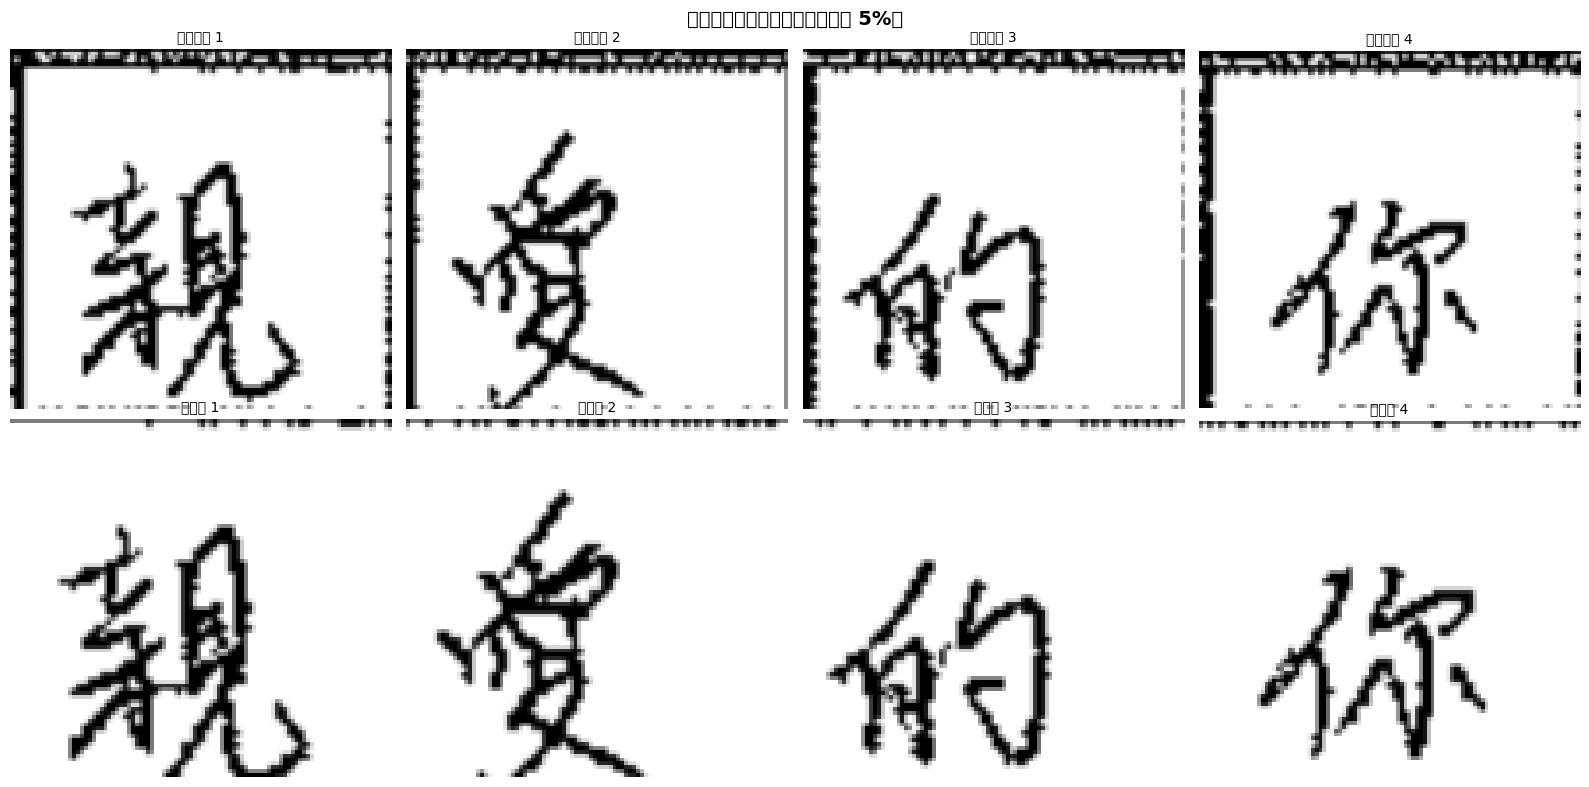

In [53]:
def crop_cell_border(cell_img, crop_ratio=0.05):
    """
    裁剪格子边缘，去除指定比例的边框
    
    Args:
        cell_img: 格子图像
        crop_ratio: 裁剪比例（0.05 表示上下左右各裁剪 5%）
    
    Returns:
        裁剪后的图像
    """
    h, w = cell_img.shape[:2]
    
    # 计算裁剪像素数
    crop_h = int(h * crop_ratio)
    crop_w = int(w * crop_ratio)
    
    # 裁剪边缘
    cropped = cell_img[crop_h:h-crop_h, crop_w:w-crop_w]
    
    return cropped

# 重新处理非空格子，裁剪边缘
cropped_cell_images = []
valid_cells = []

print("裁剪格子边缘（上下左右各 5%）...")
for cell, cell_img in zip(non_empty_cells, cell_images):
    try:
        cropped_img = crop_cell_border(cell_img, crop_ratio=0.05)
        
        # 检查裁剪后的图像是否有效
        if cropped_img.size > 0 and cropped_img.shape[0] > 0 and cropped_img.shape[1] > 0:
            cropped_cell_images.append(cropped_img)
            valid_cells.append(cell)
    except Exception as e:
        print(f"⚠️ 格子裁剪失败: {e}")
        continue

print(f"✓ 裁剪完成，有效格子数: {len(cropped_cell_images)}")

# 显示裁剪前后对比（前4个）
if len(cell_images) >= 4:
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    for i in range(min(4, len(cell_images))):
        # 原始格子
        axes[0, i].imshow(cv2.cvtColor(cell_images[i], cv2.COLOR_BGR2RGB))
        axes[0, i].set_title(f'原始格子 {i+1}', fontsize=10)
        axes[0, i].axis('off')
        
        # 裁剪后格子
        if i < len(cropped_cell_images):
            axes[1, i].imshow(cv2.cvtColor(cropped_cell_images[i], cv2.COLOR_BGR2RGB))
            axes[1, i].set_title(f'裁剪后 {i+1}', fontsize=10)
            axes[1, i].axis('off')
    
    plt.suptitle('格子裁剪对比（上下左右各去除 5%）', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

### 13.2 使用裁剪后的格子进行识别

In [54]:
# 对裁剪后的格子进行识别
recognition_results_cropped = []

print("\n开始识别（裁剪后的格子）...")
print("="*60)

for i, (cell, cell_img) in enumerate(zip(valid_cells, cropped_cell_images)):
    # 保存裁剪后的格子图片
    temp_cell_path = project_root / 'output' / f'temp_cell_cropped_{i}.png'
    cv2.imwrite(str(temp_cell_path), cell_img)
    
    # 使用 TextRecognition 识别
    result = text_rec.predict(str(temp_cell_path))
    
    if result and len(result) > 0:
        res_dict = result[0]
        text = res_dict.get('rec_text', '')
        confidence = res_dict.get('rec_score', 0.0)
    else:
        text = ''
        confidence = 0.0
    
    recognition_results_cropped.append({
        'row': cell['row'],
        'col': cell['col'],
        'text': text,
        'confidence': confidence,
        'position': (cell['x1'], cell['y1'], cell['x2'], cell['y2'])
    })
    
    # 删除临时文件
    temp_cell_path.unlink()
    
    if (i + 1) % 50 == 0:
        print(f"已识别 {i+1}/{len(cropped_cell_images)} 个格子...")

print(f"\n✓ 识别完成，共识别 {len(recognition_results_cropped)} 个格子")
print("="*60)

# 按行列顺序排序并拼接
recognition_results_cropped.sort(key=lambda x: (x['row'], x['col']))
recognized_text_cropped = ''.join([result['text'] for result in recognition_results_cropped])

print(f"\n裁剪边缘后识别字符数: {len(recognized_text_cropped)}")
print(f"裁剪前识别字符数: {len(recognized_text)}")
print(f"字符数变化: {len(recognized_text_cropped) - len(recognized_text)}")


开始识别（裁剪后的格子）...
已识别 50/607 个格子...
已识别 50/607 个格子...
已识别 100/607 个格子...
已识别 100/607 个格子...
已识别 150/607 个格子...
已识别 150/607 个格子...
已识别 200/607 个格子...
已识别 200/607 个格子...
已识别 250/607 个格子...
已识别 250/607 个格子...
已识别 300/607 个格子...
已识别 300/607 个格子...
已识别 350/607 个格子...
已识别 350/607 个格子...
已识别 400/607 个格子...
已识别 400/607 个格子...
已识别 450/607 个格子...
已识别 450/607 个格子...
已识别 500/607 个格子...
已识别 500/607 个格子...
已识别 550/607 个格子...
已识别 550/607 个格子...
已识别 600/607 个格子...

✓ 识别完成，共识别 607 个格子

裁剪边缘后识别字符数: 553
裁剪前识别字符数: 529
字符数变化: 24
已识别 600/607 个格子...

✓ 识别完成，共识别 607 个格子

裁剪边缘后识别字符数: 553
裁剪前识别字符数: 529
字符数变化: 24


### 13.3 过滤低置信度结果（< 0.3）

In [55]:
# 过滤置信度低于 0.3 的结果
confidence_threshold_new = 0.3

# 统计置信度分布
confidences_cropped = [r['confidence'] for r in recognition_results_cropped]
low_conf_count_new = sum(1 for c in confidences_cropped if c < confidence_threshold_new)

print("="*60)
print("置信度分布分析（裁剪边缘后）")
print("="*60)
print(f"总字符数: {len(confidences_cropped)}")
print(f"低置信度字符数 (< {confidence_threshold_new}): {low_conf_count_new} ({low_conf_count_new/len(confidences_cropped)*100:.1f}%)")
print(f"平均置信度: {np.mean(confidences_cropped):.3f}")
print(f"最低置信度: {np.min(confidences_cropped):.3f}")
print(f"最高置信度: {np.max(confidences_cropped):.3f}")
print("="*60)

# 过滤并拼接文本
filtered_results_cropped = [r for r in recognition_results_cropped if r['confidence'] >= confidence_threshold_new]
filtered_text_cropped = ''.join([r['text'] for r in filtered_results_cropped])

print(f"\n过滤后字符数: {len(filtered_text_cropped)}")
print(f"过滤前字符数: {len(recognized_text_cropped)}")
print(f"移除字符数: {len(recognized_text_cropped) - len(filtered_text_cropped)}")

# 显示被过滤掉的低置信度字符
low_conf_samples_new = [(r['text'], r['confidence']) for r in recognition_results_cropped if r['confidence'] < confidence_threshold_new]
if low_conf_samples_new:
    print(f"\n被过滤的低置信度字符样例（前20个）:")
    for i, (text, conf) in enumerate(low_conf_samples_new[:20]):
        print(f"  {i+1:2d}. '{text}' (置信度: {conf:.3f})")
print("="*60)

置信度分布分析（裁剪边缘后）
总字符数: 607
低置信度字符数 (< 0.3): 108 (17.8%)
平均置信度: 0.701
最低置信度: 0.000
最高置信度: 1.000

过滤后字符数: 503
过滤前字符数: 553
移除字符数: 50

被过滤的低置信度字符样例（前20个）:
   1. '' (置信度: 0.000)
   2. '' (置信度: 0.000)
   3. '−' (置信度: 0.142)
   4. '→' (置信度: 0.096)
   5. '' (置信度: 0.000)
   6. '' (置信度: 0.000)
   7. '' (置信度: 0.000)
   8. '' (置信度: 0.000)
   9. '' (置信度: 0.000)
  10. '' (置信度: 0.000)
  11. '' (置信度: 0.000)
  12. '−' (置信度: 0.258)
  13. '' (置信度: 0.000)
  14. '！' (置信度: 0.197)
  15. '' (置信度: 0.000)
  16. '' (置信度: 0.000)
  17. '' (置信度: 0.000)
  18. '討' (置信度: 0.199)
  19. '' (置信度: 0.000)
  20. '•' (置信度: 0.192)


### 13.4 L1/L2 错误分析

**L1 错误（Type I Error）**: 误识别，即预测结果中出现了本不应该出现的字符（False Positive）  
**L2 错误（Type II Error）**: 漏识别,即应该识别出的字符没有被识别出来（False Negative）

通过分析这两类错误，可以更深入地了解模型的识别问题。

In [56]:
import difflib

def calculate_l1_l2_errors(predicted, ground_truth):
    """
    计算 L1 和 L2 错误
    
    L1 错误（False Positive）: predicted 中多余的字符
    L2 错误（False Negative）: ground_truth 中缺失的字符
    
    参数:
    - predicted: 预测文本
    - ground_truth: 标准答案文本
    
    返回:
    - l1_errors: L1 错误列表 [(字符, 位置), ...]
    - l2_errors: L2 错误列表 [(字符, 位置), ...]
    - l1_count: L1 错误数量
    - l2_count: L2 错误数量
    """
    # 使用 SequenceMatcher 进行逐字符对比
    matcher = difflib.SequenceMatcher(None, ground_truth, predicted)
    
    l1_errors = []  # False Positive (多余的字符)
    l2_errors = []  # False Negative (缺失的字符)
    
    # 遍历所有操作
    for tag, i1, i2, j1, j2 in matcher.get_opcodes():
        if tag == 'delete':
            # ground_truth 中有，predicted 中没有 → L2 错误（漏识别）
            for i in range(i1, i2):
                l2_errors.append((ground_truth[i], i))
        elif tag == 'insert':
            # predicted 中有，ground_truth 中没有 → L1 错误（误识别）
            for j in range(j1, j2):
                l1_errors.append((predicted[j], j))
        elif tag == 'replace':
            # 替换操作：既有漏识别又有误识别
            for i in range(i1, i2):
                l2_errors.append((ground_truth[i], i))
            for j in range(j1, j2):
                l1_errors.append((predicted[j], j))
    
    return l1_errors, l2_errors, len(l1_errors), len(l2_errors)


# 计算裁剪+过滤方案的 L1/L2 错误
l1_errors, l2_errors, l1_count, l2_count = calculate_l1_l2_errors(filtered_text_cropped, gt_clean)

print("="*60)
print("L1/L2 错误分析（裁剪边缘 + 过滤置信度 < 0.3）")
print("="*60)
print(f"Ground Truth 长度: {len(gt_clean)}")
print(f"预测文本长度: {len(filtered_text_cropped)}")
print(f"\nL1 错误（误识别 / False Positive）: {l1_count}")
print(f"L2 错误（漏识别 / False Negative）: {l2_count}")
print(f"总错误数: {l1_count + l2_count}")
print("="*60)

# 显示 L1 错误样例（前20个）
if l1_errors:
    print(f"\nL1 错误样例（误识别，前20个）:")
    for i, (char, pos) in enumerate(l1_errors[:20]):
        print(f"  {i+1:2d}. 位置 {pos:3d}: '{char}'")

# 显示 L2 错误样例（前20个）
if l2_errors:
    print(f"\nL2 错误样例（漏识别，前20个）:")
    for i, (char, pos) in enumerate(l2_errors[:20]):
        print(f"  {i+1:2d}. 位置 {pos:3d}: '{char}'")

# 错误率统计
l1_rate = l1_count / len(gt_clean) * 100 if len(gt_clean) > 0 else 0
l2_rate = l2_count / len(gt_clean) * 100 if len(gt_clean) > 0 else 0

print(f"\nL1 错误率: {l1_rate:.2f}%")
print(f"L2 错误率: {l2_rate:.2f}%")
print("="*60)

L1/L2 错误分析（裁剪边缘 + 过滤置信度 < 0.3）
Ground Truth 长度: 552
预测文本长度: 503

L1 错误（误识别 / False Positive）: 111
L2 错误（漏识别 / False Negative）: 160
总错误数: 271

L1 错误样例（误识别，前20个）:
   1. 位置   1: '爱'
   2. 位置   5: '−'
   3. 位置   6: '−'
   4. 位置   7: '−'
   5. 位置   8: '−'
   6. 位置   9: '−'
   7. 位置  14: '-'
   8. 位置  25: '。'
   9. 位置  26: '`'
  10. 位置  31: '为'
  11. 位置  41: '竞'
  12. 位置  42: '我'
  13. 位置  43: '俩'
  14. 位置  46: '谋'
  15. 位置  54: '-'
  16. 位置  60: '寶'
  17. 位置  61: '在'
  18. 位置  62: '易'
  19. 位置  68: '纪'
  20. 位置  81: '為'

L2 错误样例（漏识别，前20个）:
   1. 位置   1: '愛'
   2. 位置   7: '！'
   3. 位置  10: '一'
   4. 位置  21: '，'
   5. 位置  26: '爲'
   6. 位置  36: '竟'
   7. 位置  37: '我'
   8. 位置  38: '倆'
   9. 位置  41: '謀'
  10. 位置  49: '一'
  11. 位置  55: '實'
  12. 位置  56: '在'
  13. 位置  57: '寫'
  14. 位置  63: '絕'
  15. 位置  66: '討'
  16. 位置  77: '爲'
  17. 位置  80: '著'
  18. 位置  87: '石'
  19. 位置  91: '閲'
  20. 位置 101: '爲'

L1 错误率: 20.11%
L2 错误率: 28.99%


### 13.5 最终评估和方案对比

对比所有优化方案的性能，评估最终效果。

最终方案评估（裁剪边缘 5% + 过滤置信度 < 0.3）
准确率: 70.65%
相似度: 73.93%
Ground Truth 长度: 552
预测文本长度: 503
匹配字符数: 390

所有方案对比:
------------------------------------------------------------
原图（有竖线）...................................... 53.62%
v3_width9（删除竖线）.............................. 65.76%
格子分割方案（未过滤）.................................. 66.85%
格子分割 + 置信度过滤(≥0.4)........................... 65.22%
格子分割 + 裁剪边缘 + 过滤(≥0.3)....................... 70.65%


C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\3013160758.py:48: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\3013160758.py:48: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\3013160758.py:48: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\3013160758.py:48: UserWarning: Glyph 26377 (\N{CJK UNIFIED IDEOGRAPH-6709}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\3013160758.py:48: UserWarning: Glyph 31446 (\N{CJK UNIFIED IDEOGRAPH-7AD6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\3013160758.py:48: UserWarning: Gl

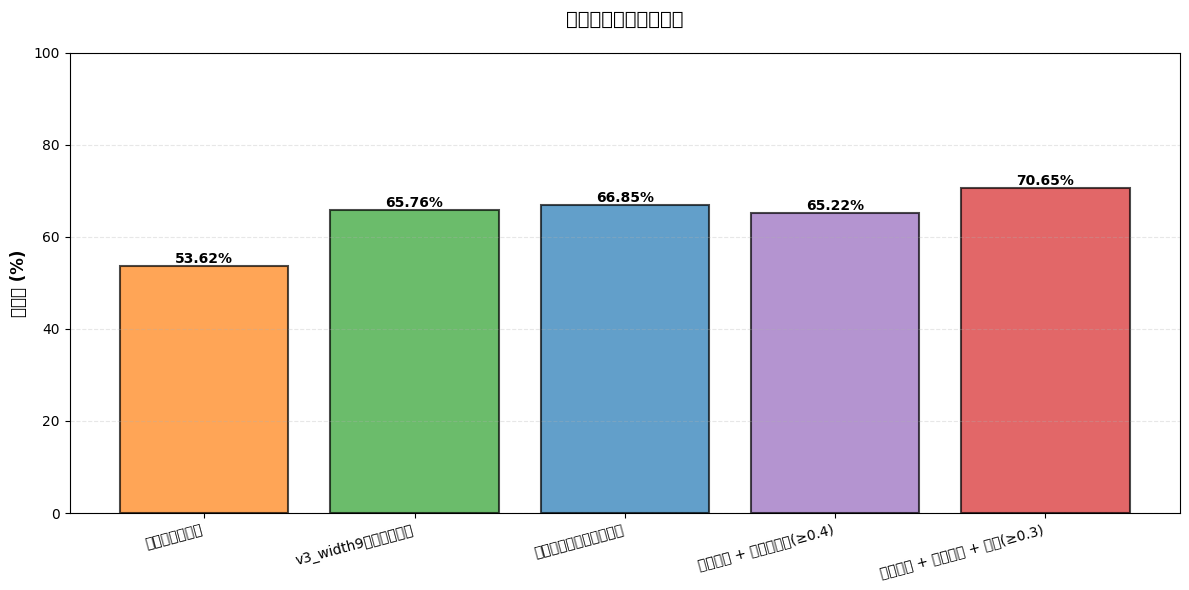


对比结果已保存到: c:\Users\Quenton\Documents\Github\writtingOCR\output\accuracy_comparison_final.json

改进幅度分析:
------------------------------------------------------------
相比原图方案: +17.03%
相比 v3_width9 方案: +4.89%
相比格子分割（未过滤）: +3.80%
相比格子分割+过滤(≥0.4): +5.43%

生成可视化对比图...


C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\3518806100.py:94: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\3518806100.py:94: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\3518806100.py:94: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\3518806100.py:94: UserWarning: Glyph 20687 (\N{CJK UNIFIED IDEOGRAPH-50CF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\3518806100.py:94: UserWarning: Glyph 35782 (\N{CJK UNIFIED IDEOGRAPH-8BC6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\3518806100.py:94: UserWarning: Gl

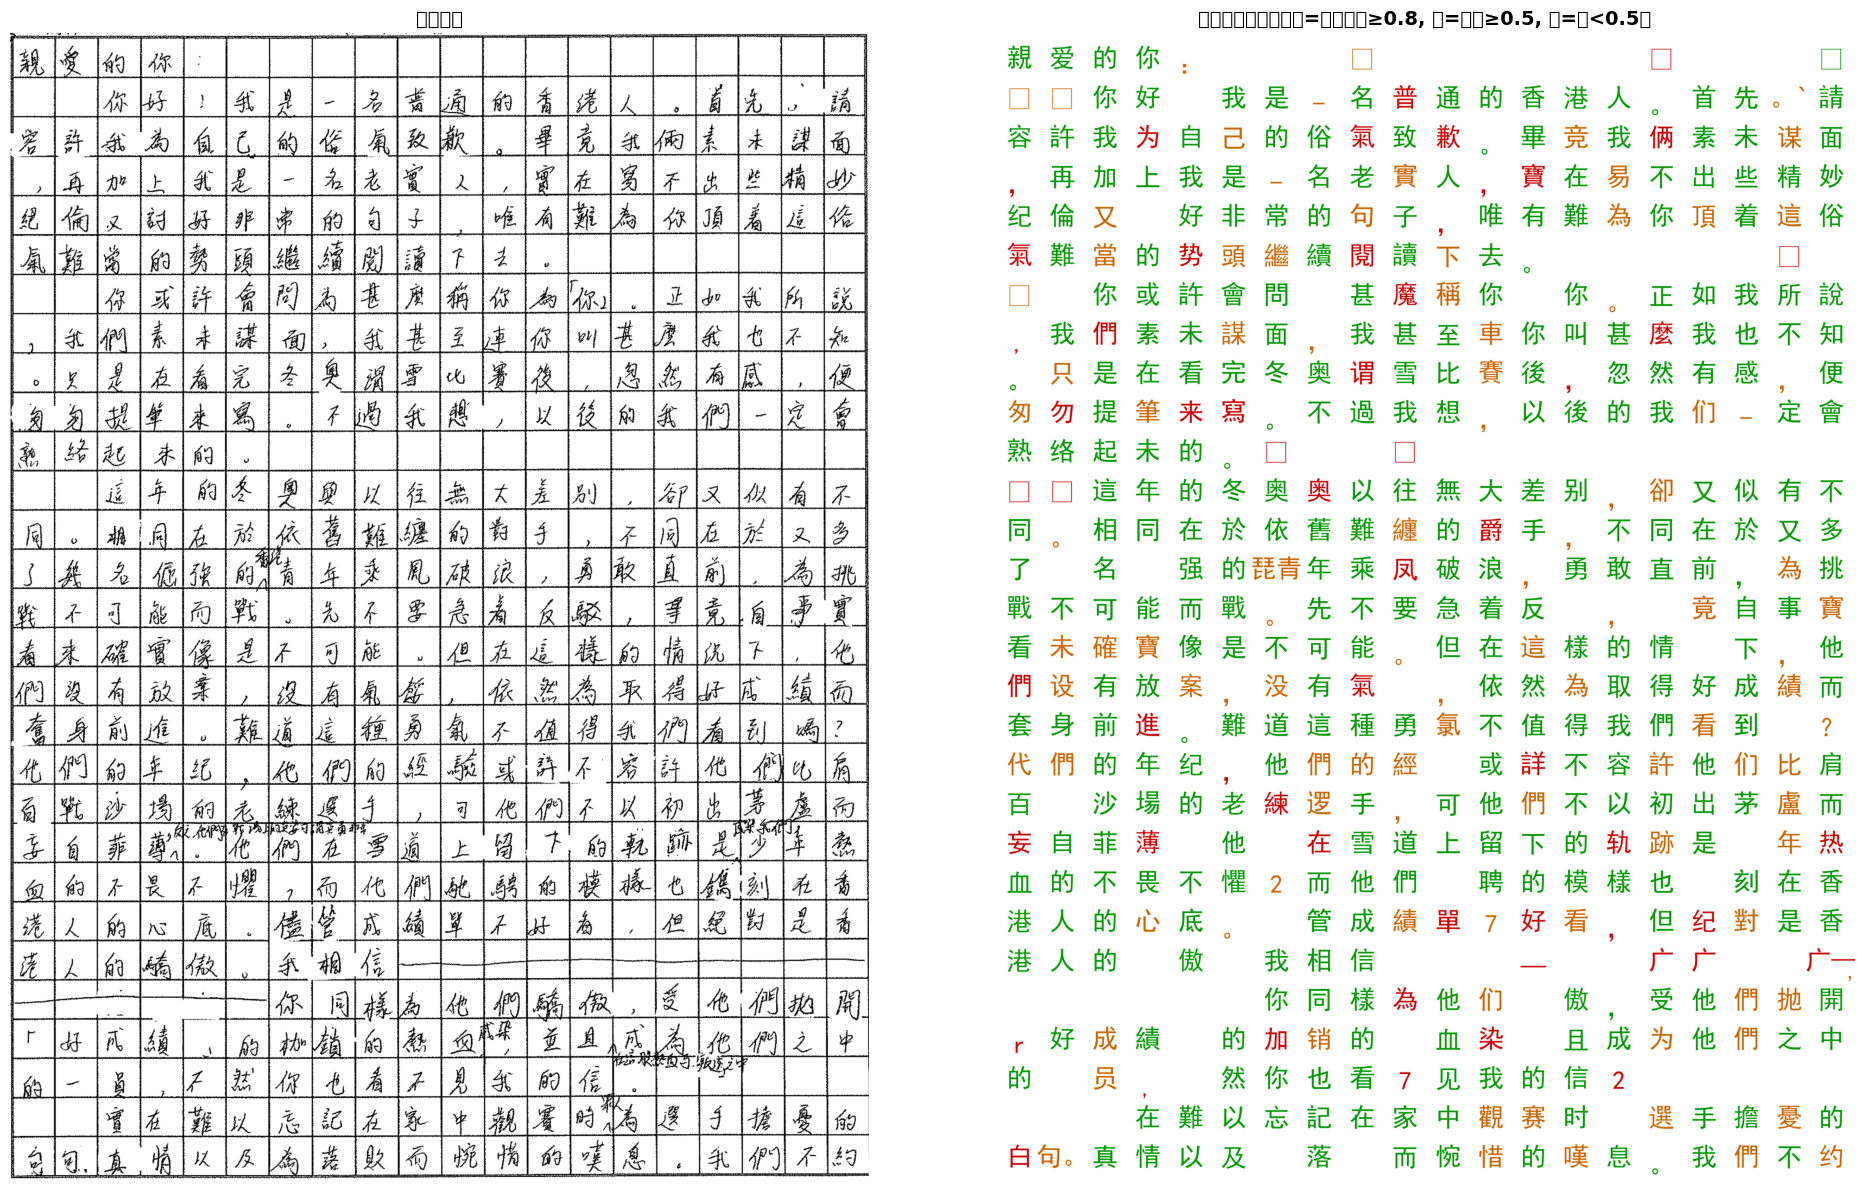

可视化结果已保存到: c:\Users\Quenton\Documents\Github\writtingOCR\output\grid_ocr_cropped_filtered_comparison.png


In [64]:
# 计算最终方案（裁剪边缘 + 过滤置信度 < 0.3）的准确率
metrics_cropped_filtered = calculate_accuracy(filtered_text_cropped, gt_clean)

print("="*60)
print("最终方案评估（裁剪边缘 5% + 过滤置信度 < 0.3）")
print("="*60)
print(f"准确率: {metrics_cropped_filtered['accuracy']:.2f}%")
print(f"相似度: {metrics_cropped_filtered['similarity']:.2f}%")
print(f"Ground Truth 长度: {metrics_cropped_filtered['total_chars']}")
print(f"预测文本长度: {len(filtered_text_cropped)}")
print(f"匹配字符数: {metrics_cropped_filtered['matched_chars']}")
print("="*60)

# 对比所有方案
comparison_data_final = {
    '原图（有竖线）': 53.62,
    'v3_width9（删除竖线）': 65.76,
    '格子分割方案（未过滤）': metrics['accuracy'],
    '格子分割 + 置信度过滤(≥0.4)': metrics_filtered['accuracy'],
    '格子分割 + 裁剪边缘 + 过滤(≥0.3)': metrics_cropped_filtered['accuracy']
}

print("\n所有方案对比:")
print("-"*60)
for method, acc in comparison_data_final.items():
    print(f"{method:.<45} {acc:.2f}%")
print("="*60)

# 可视化对比
fig, ax = plt.subplots(figsize=(12, 6))
methods = list(comparison_data_final.keys())
accuracies = list(comparison_data_final.values())
colors = ['#ff7f0e', '#2ca02c', '#1f77b4', '#9467bd', '#d62728']
bars = ax.bar(methods, accuracies, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)

# 添加数值标签
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}%',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_ylabel('准确率 (%)', fontsize=12, fontweight='bold')
ax.set_title('不同方案的准确率对比', fontsize=14, fontweight='bold', pad=20)
ax.set_ylim(0, 100)
ax.grid(axis='y', alpha=0.3, linestyle='--')
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()

# 保存对比结果
comparison_output_path = project_root / 'output' / 'accuracy_comparison_final.json'
comparison_output_path.parent.mkdir(parents=True, exist_ok=True)
with open(comparison_output_path, 'w', encoding='utf-8') as f:
    json.dump({
        'comparison': comparison_data_final,
        'final_metrics': metrics_cropped_filtered,
        'l1_errors': l1_count,
        'l2_errors': l2_count,
        'filtered_out_count': len(recognized_text_cropped) - len(filtered_text_cropped)
    }, f, ensure_ascii=False, indent=2)

print(f"\n对比结果已保存到: {comparison_output_path}")

# 计算改进幅度
improvement_from_original = metrics_cropped_filtered['accuracy'] - 53.62
improvement_from_v3 = metrics_cropped_filtered['accuracy'] - 65.76
improvement_from_grid = metrics_cropped_filtered['accuracy'] - metrics['accuracy']
improvement_from_filtered = metrics_cropped_filtered['accuracy'] - metrics_filtered['accuracy']

print("\n改进幅度分析:")
print("-"*60)
print(f"相比原图方案: +{improvement_from_original:.2f}%")
print(f"相比 v3_width9 方案: +{improvement_from_v3:.2f}%")
print(f"相比格子分割（未过滤）: +{improvement_from_grid:.2f}%")
print(f"相比格子分割+过滤(≥0.4): +{improvement_from_filtered:.2f}%")
print("="*60)

# 可视化裁剪+过滤方案的识别结果
print("\n生成可视化对比图...")
result_image_final = visualize_ocr_results(img_rgb, filtered_results_cropped, font_size=65)

# 保存可视化结果
final_vis_path = project_root / 'output' / 'grid_ocr_cropped_filtered_comparison.png'
result_image_final.save(final_vis_path)
print(f"可视化结果已保存到: {final_vis_path}")

---

## 14. 特殊对比：忽略 insert 标签内容

假设看不见 `<insert>` 标签之间的内容，对比三个主要方案的准确度。

In [65]:
# 重新处理 Ground Truth：完全删除 <insert></insert> 及其之间的内容
with open(gt_file, 'r', encoding='utf-8') as f:
    ground_truth_original = f.read()

# 使用正则表达式删除 <insert>...</insert> 整个片段
import re
gt_no_insert = re.sub(r'<insert>.*?</insert>', '', ground_truth_original, flags=re.DOTALL)

# 只删除 <?> 标记，保留其他内容
gt_no_insert = gt_no_insert.replace('<?>', '')

# 清理空白
gt_no_insert_clean = gt_no_insert.replace('\n', '').replace(' ', '')

print("="*60)
print("Ground Truth 处理对比")
print("="*60)
print(f"原始 Ground Truth (包含 insert): {len(gt_clean)} 字符")
print(f"删除 insert 内容后: {len(gt_no_insert_clean)} 字符")
print(f"差异: {len(gt_clean) - len(gt_no_insert_clean)} 字符")
print("="*60)

print(f"\n删除 insert 后的 Ground Truth 前 200 字符:")
print(gt_no_insert_clean[:200])
print("="*60)

Ground Truth 处理对比
原始 Ground Truth (包含 insert): 552 字符
删除 insert 内容后: 516 字符
差异: 36 字符

删除 insert 后的 Ground Truth 前 200 字符:
親愛的你：你好！我是一名普通的香港人。首先，請容許我爲自己的俗氣致歉。畢竟我倆素未謀面，再加上我是一名老實人，實在寫不出些精妙絕倫又討好非常的句子，唯有難爲你頂著這俗氣難當的石頭繼續閲讀下去。你或許會問爲甚麽稱你爲「你」。正如我所説，我們素未謀面，我甚至連你叫甚麽我也不知。只是在看完冬奧滑雪比賽後，忽然有感，便匆匆提筆來寫。不過我想，以後的我們一定會熟絡起來的。這年的冬奧與以往五大差別，卻又似有不


In [66]:
# 计算三个主要方案对比删除 insert 后的 Ground Truth 的准确率

# 方案 1: 格子分割方案（未过滤）
metrics_no_insert_1 = calculate_accuracy(recognized_text, gt_no_insert_clean)

# 方案 2: 格子分割 + 置信度过滤(≥0.4)
metrics_no_insert_2 = calculate_accuracy(filtered_text, gt_no_insert_clean)

# 方案 3: 格子分割 + 裁剪边缘 + 过滤(≥0.3)
metrics_no_insert_3 = calculate_accuracy(filtered_text_cropped, gt_no_insert_clean)

print("="*80)
print("忽略 insert 标签内容的准确率对比")
print("="*80)

print("\n【方案 1】格子分割方案（未过滤）:")
print(f"  准确率: {metrics_no_insert_1['accuracy']:.2f}%")
print(f"  相似度: {metrics_no_insert_1['similarity']:.2f}%")
print(f"  匹配字符数: {metrics_no_insert_1['matched_chars']}/{metrics_no_insert_1['total_chars']}")

print("\n【方案 2】格子分割 + 置信度过滤(≥0.4):")
print(f"  准确率: {metrics_no_insert_2['accuracy']:.2f}%")
print(f"  相似度: {metrics_no_insert_2['similarity']:.2f}%")
print(f"  匹配字符数: {metrics_no_insert_2['matched_chars']}/{metrics_no_insert_2['total_chars']}")

print("\n【方案 3】格子分割 + 裁剪边缘 + 过滤(≥0.3):")
print(f"  准确率: {metrics_no_insert_3['accuracy']:.2f}%")
print(f"  相似度: {metrics_no_insert_3['similarity']:.2f}%")
print(f"  匹配字符数: {metrics_no_insert_3['matched_chars']}/{metrics_no_insert_3['total_chars']}")

print("\n" + "="*80)

# 对比：包含 insert vs 忽略 insert
comparison_insert_impact = {
    '方案': ['格子分割（未过滤）', '格子分割+过滤(≥0.4)', '格子分割+裁剪+过滤(≥0.3)'],
    '包含 insert': [
        metrics['accuracy'],
        metrics_filtered['accuracy'],
        metrics_cropped_filtered['accuracy']
    ],
    '忽略 insert': [
        metrics_no_insert_1['accuracy'],
        metrics_no_insert_2['accuracy'],
        metrics_no_insert_3['accuracy']
    ]
}

print("\n准确率对比表（包含 insert vs 忽略 insert）:")
print("-"*80)
print(f"{'方案':<30} {'包含 insert':>15} {'忽略 insert':>15} {'差异':>10}")
print("-"*80)
for i in range(len(comparison_insert_impact['方案'])):
    method = comparison_insert_impact['方案'][i]
    with_insert = comparison_insert_impact['包含 insert'][i]
    without_insert = comparison_insert_impact['忽略 insert'][i]
    diff = without_insert - with_insert
    print(f"{method:<30} {with_insert:>14.2f}% {without_insert:>14.2f}% {diff:>9.2f}%")
print("="*80)

忽略 insert 标签内容的准确率对比

【方案 1】格子分割方案（未过滤）:
  准确率: 71.90%
  相似度: 71.00%
  匹配字符数: 371/516

【方案 2】格子分割 + 置信度过滤(≥0.4):
  准确率: 70.35%
  相似度: 73.11%
  匹配字符数: 363/516

【方案 3】格子分割 + 裁剪边缘 + 过滤(≥0.3):
  准确率: 76.16%
  相似度: 77.13%
  匹配字符数: 393/516


准确率对比表（包含 insert vs 忽略 insert）:
--------------------------------------------------------------------------------
方案                                   包含 insert       忽略 insert         差异
--------------------------------------------------------------------------------
格子分割（未过滤）                               66.85%          71.90%      5.05%
格子分割+过滤(≥0.4)                           65.22%          70.35%      5.13%
格子分割+裁剪+过滤(≥0.3)                        70.65%          76.16%      5.51%


C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\1147132953.py:49: UserWarning: Glyph 26684 (\N{CJK UNIFIED IDEOGRAPH-683C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\1147132953.py:49: UserWarning: Glyph 23376 (\N{CJK UNIFIED IDEOGRAPH-5B50}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\1147132953.py:49: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\1147132953.py:49: UserWarning: Glyph 21106 (\N{CJK UNIFIED IDEOGRAPH-5272}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\1147132953.py:49: UserWarning: Glyph 26410 (\N{CJK UNIFIED IDEOGRAPH-672A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\1147132953.py:49: UserWarning: Gl

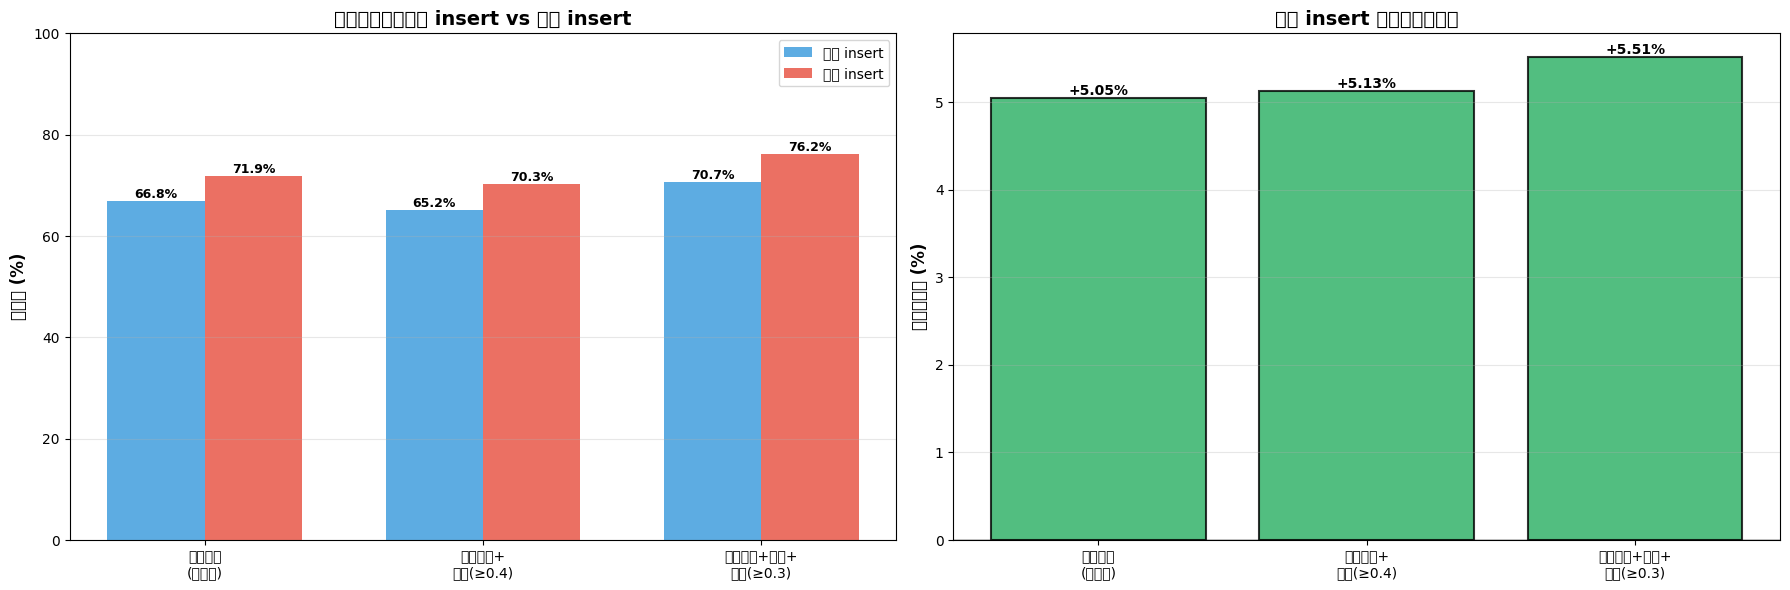


分析:
--------------------------------------------------------------------------------
✓ 所有方案在忽略 insert 内容后准确率均有提升
  说明：insert 标签内的内容对识别造成了额外的困难

平均准确率差异: 5.23%


In [67]:
# 可视化对比：包含 insert vs 忽略 insert
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

methods_short = ['格子分割\n(未过滤)', '格子分割+\n过滤(≥0.4)', '格子分割+裁剪+\n过滤(≥0.3)']
x = np.arange(len(methods_short))
width = 0.35

# 左图：准确率对比
bars1 = ax1.bar(x - width/2, comparison_insert_impact['包含 insert'], width, 
                label='包含 insert', color='#3498db', alpha=0.8)
bars2 = ax1.bar(x + width/2, comparison_insert_impact['忽略 insert'], width,
                label='忽略 insert', color='#e74c3c', alpha=0.8)

ax1.set_ylabel('准确率 (%)', fontsize=12, fontweight='bold')
ax1.set_title('准确率对比：包含 insert vs 忽略 insert', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(methods_short)
ax1.legend(fontsize=10)
ax1.set_ylim(0, 100)
ax1.grid(axis='y', alpha=0.3)

# 添加数值标签
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

# 右图：准确率差异
diffs = [comparison_insert_impact['忽略 insert'][i] - comparison_insert_impact['包含 insert'][i] 
         for i in range(len(methods_short))]
colors_diff = ['#27ae60' if d > 0 else '#e74c3c' for d in diffs]
bars3 = ax2.bar(methods_short, diffs, color=colors_diff, alpha=0.8, edgecolor='black', linewidth=1.5)

ax2.set_ylabel('准确率差异 (%)', fontsize=12, fontweight='bold')
ax2.set_title('忽略 insert 后的准确率变化', fontsize=14, fontweight='bold')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax2.grid(axis='y', alpha=0.3)

# 添加数值标签
for bar, diff in zip(bars3, diffs):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{diff:+.2f}%',
            ha='center', va='bottom' if diff > 0 else 'top', 
            fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n分析:")
print("-"*80)
if all(d > 0 for d in diffs):
    print("✓ 所有方案在忽略 insert 内容后准确率均有提升")
    print("  说明：insert 标签内的内容对识别造成了额外的困难")
elif all(d < 0 for d in diffs):
    print("✓ 所有方案在忽略 insert 内容后准确率均下降")
    print("  说明：insert 标签内的内容反而更容易被正确识别")
else:
    print("✓ 不同方案对 insert 内容的敏感度不同")
    
print(f"\n平均准确率差异: {np.mean(diffs):.2f}%")
print("="*80)

---

## 15. 方案 4：自适应裁剪策略

**问题发现：**
- 裁剪边缘虽然能减少格子线误识别，但也可能导致写到边缘的字符被裁掉
- 不同格子的最佳裁剪比例不同

**解决方案：自适应裁剪 + 早停策略**
1. 预处理：为每个格子准备 3 个版本（不裁剪、裁剪5%、裁剪10%）
2. 识别策略（早停）：
   - 先识别不裁剪 → 置信度 ≥ 80% → 采用，跳过裁剪
   - 置信度 < 80% → 识别裁剪5% → 置信度 ≥ 80% → 采用，跳过10%
   - 仍 < 80% → 识别裁剪10% → 对比三次，选置信度最高的

**优势：**
- 自适应选择最佳裁剪比例
- 早停策略节省计算资源
- 避免过度裁剪导致字符丢失

### 15.1 准备三种裁剪版本的格子

准备三种裁剪版本...
✓ 完成！共准备 607 个格子的三种版本


C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\1687005993.py:64: UserWarning: Glyph 26684 (\N{CJK UNIFIED IDEOGRAPH-683C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\1687005993.py:64: UserWarning: Glyph 23376 (\N{CJK UNIFIED IDEOGRAPH-5B50}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\1687005993.py:64: UserWarning: Glyph 19981 (\N{CJK UNIFIED IDEOGRAPH-4E0D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\1687005993.py:64: UserWarning: Glyph 35009 (\N{CJK UNIFIED IDEOGRAPH-88C1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\1687005993.py:64: UserWarning: Glyph 21098 (\N{CJK UNIFIED IDEOGRAPH-526A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\1687005993.py:64: UserWarning: Gl

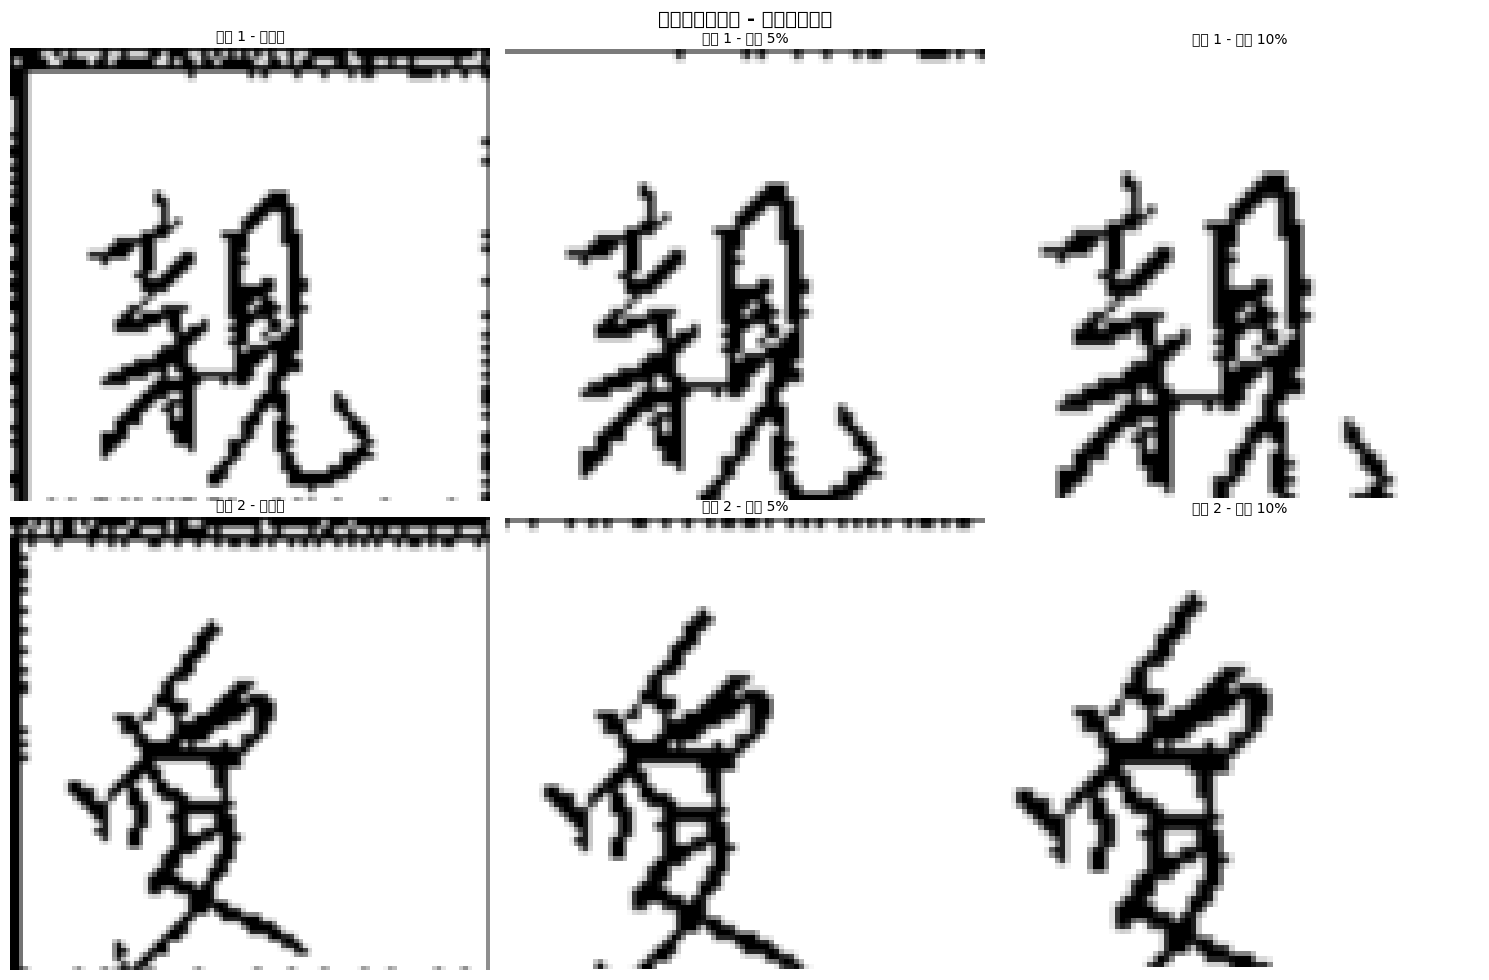

In [68]:
# 为每个非空格子准备三种裁剪版本
cell_variants = []  # 每个元素是 {'cell': cell_info, 'no_crop': img, 'crop_5': img, 'crop_10': img}

print("准备三种裁剪版本...")
for cell, cell_img in zip(non_empty_cells, cell_images):
    variants = {
        'cell': cell,
        'no_crop': cell_img.copy(),
        'crop_5': None,
        'crop_10': None
    }
    
    # 裁剪 5%
    try:
        cropped_5 = crop_cell_border(cell_img, crop_ratio=0.05)
        if cropped_5.size > 0 and cropped_5.shape[0] > 0 and cropped_5.shape[1] > 0:
            variants['crop_5'] = cropped_5
    except:
        pass
    
    # 裁剪 10%
    try:
        cropped_10 = crop_cell_border(cell_img, crop_ratio=0.10)
        if cropped_10.size > 0 and cropped_10.shape[0] > 0 and cropped_10.shape[1] > 0:
            variants['crop_10'] = cropped_10
    except:
        pass
    
    cell_variants.append(variants)

print(f"✓ 完成！共准备 {len(cell_variants)} 个格子的三种版本")

# 显示前 2 个格子的三种版本对比
if len(cell_variants) >= 2:
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    for i in range(min(2, len(cell_variants))):
        variants = cell_variants[i]
        
        # 不裁剪
        axes[i, 0].imshow(cv2.cvtColor(variants['no_crop'], cv2.COLOR_BGR2RGB))
        axes[i, 0].set_title(f'格子 {i+1} - 不裁剪', fontsize=10)
        axes[i, 0].axis('off')
        
        # 裁剪 5%
        if variants['crop_5'] is not None:
            axes[i, 1].imshow(cv2.cvtColor(variants['crop_5'], cv2.COLOR_BGR2RGB))
            axes[i, 1].set_title(f'格子 {i+1} - 裁剪 5%', fontsize=10)
        else:
            axes[i, 1].text(0.5, 0.5, '裁剪失败', ha='center', va='center')
            axes[i, 1].set_title(f'格子 {i+1} - 裁剪 5%', fontsize=10)
        axes[i, 1].axis('off')
        
        # 裁剪 10%
        if variants['crop_10'] is not None:
            axes[i, 2].imshow(cv2.cvtColor(variants['crop_10'], cv2.COLOR_BGR2RGB))
            axes[i, 2].set_title(f'格子 {i+1} - 裁剪 10%', fontsize=10)
        else:
            axes[i, 2].text(0.5, 0.5, '裁剪失败', ha='center', va='center')
            axes[i, 2].set_title(f'格子 {i+1} - 裁剪 10%', fontsize=10)
        axes[i, 2].axis('off')
    
    plt.suptitle('自适应裁剪策略 - 三种版本对比', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

### 15.2 自适应识别（早停策略）

In [69]:
def recognize_cell_image(cell_img, idx):
    """
    识别单个格子图像
    
    Args:
        cell_img: 格子图像
        idx: 格子索引（用于临时文件命名）
    
    Returns:
        (text, confidence) 或 (None, None) 如果识别失败
    """
    if cell_img is None:
        return None, None
    
    temp_path = project_root / 'output' / f'temp_adaptive_{idx}.png'
    try:
        cv2.imwrite(str(temp_path), cell_img)
        result = text_rec.predict(str(temp_path))
        
        if result and len(result) > 0:
            res_dict = result[0]
            text = res_dict.get('rec_text', '')
            confidence = res_dict.get('rec_score', 0.0)
            return text, confidence
        else:
            return '', 0.0
    except Exception as e:
        print(f"⚠️ 识别失败: {e}")
        return None, None
    finally:
        if temp_path.exists():
            temp_path.unlink()


# 自适应识别（早停策略）
recognition_results_adaptive = []
confidence_threshold_high = 0.80  # 早停阈值

# 统计信息
stats_adaptive = {
    'used_no_crop': 0,      # 使用不裁剪版本的数量
    'used_crop_5': 0,       # 使用裁剪5%版本的数量
    'used_crop_10': 0,      # 使用裁剪10%版本的数量
    'compared_all_3': 0     # 需要对比三次的数量
}

print("\n开始自适应识别（早停策略）...")
print("="*60)

for i, variants in enumerate(cell_variants):
    cell = variants['cell']
    
    # 第一步：识别不裁剪版本
    text_no_crop, conf_no_crop = recognize_cell_image(variants['no_crop'], f'{i}_no_crop')
    
    if conf_no_crop is not None and conf_no_crop >= confidence_threshold_high:
        # 置信度够高，直接采用
        final_text = text_no_crop
        final_conf = conf_no_crop
        final_version = 'no_crop'
        stats_adaptive['used_no_crop'] += 1
    else:
        # 第二步：识别裁剪5%版本
        text_crop_5, conf_crop_5 = recognize_cell_image(variants['crop_5'], f'{i}_crop_5')
        
        if conf_crop_5 is not None and conf_crop_5 >= confidence_threshold_high:
            # 置信度够高，采用裁剪5%
            final_text = text_crop_5
            final_conf = conf_crop_5
            final_version = 'crop_5'
            stats_adaptive['used_crop_5'] += 1
        else:
            # 第三步：识别裁剪10%版本，然后对比三次结果
            text_crop_10, conf_crop_10 = recognize_cell_image(variants['crop_10'], f'{i}_crop_10')
            
            # 对比三次结果，选置信度最高的
            results = [
                (text_no_crop, conf_no_crop if conf_no_crop is not None else 0.0, 'no_crop'),
                (text_crop_5, conf_crop_5 if conf_crop_5 is not None else 0.0, 'crop_5'),
                (text_crop_10, conf_crop_10 if conf_crop_10 is not None else 0.0, 'crop_10')
            ]
            
            # 选择置信度最高的
            best_result = max(results, key=lambda x: x[1])
            final_text = best_result[0]
            final_conf = best_result[1]
            final_version = best_result[2]
            
            stats_adaptive['compared_all_3'] += 1
            if final_version == 'no_crop':
                stats_adaptive['used_no_crop'] += 1
            elif final_version == 'crop_5':
                stats_adaptive['used_crop_5'] += 1
            elif final_version == 'crop_10':
                stats_adaptive['used_crop_10'] += 1
    
    # 保存结果
    recognition_results_adaptive.append({
        'row': cell['row'],
        'col': cell['col'],
        'text': final_text,
        'confidence': final_conf,
        'version': final_version,
        'position': (cell['x1'], cell['y1'], cell['x2'], cell['y2'])
    })
    
    if (i + 1) % 50 == 0:
        print(f"已识别 {i+1}/{len(cell_variants)} 个格子...")

print(f"\n✓ 识别完成，共识别 {len(recognition_results_adaptive)} 个格子")
print("="*60)

# 显示统计信息
print("\n自适应识别统计:")
print("="*60)
print(f"使用不裁剪版本: {stats_adaptive['used_no_crop']} 个 ({stats_adaptive['used_no_crop']/len(cell_variants)*100:.1f}%)")
print(f"使用裁剪5%版本: {stats_adaptive['used_crop_5']} 个 ({stats_adaptive['used_crop_5']/len(cell_variants)*100:.1f}%)")
print(f"使用裁剪10%版本: {stats_adaptive['used_crop_10']} 个 ({stats_adaptive['used_crop_10']/len(cell_variants)*100:.1f}%)")
print(f"需要对比三次: {stats_adaptive['compared_all_3']} 个 ({stats_adaptive['compared_all_3']/len(cell_variants)*100:.1f}%)")
print("="*60)


开始自适应识别（早停策略）...
已识别 50/607 个格子...
已识别 100/607 个格子...
已识别 150/607 个格子...
已识别 200/607 个格子...
已识别 250/607 个格子...
已识别 300/607 个格子...
已识别 350/607 个格子...
已识别 400/607 个格子...
已识别 450/607 个格子...
已识别 500/607 个格子...
已识别 550/607 个格子...
已识别 600/607 个格子...

✓ 识别完成，共识别 607 个格子

自适应识别统计:
使用不裁剪版本: 417 个 (68.7%)
使用裁剪5%版本: 117 个 (19.3%)
使用裁剪10%版本: 73 个 (12.0%)
需要对比三次: 251 个 (41.4%)


### 15.3 拼接和过滤结果

In [70]:
# 按行列顺序排序并拼接
recognition_results_adaptive.sort(key=lambda x: (x['row'], x['col']))
recognized_text_adaptive = ''.join([r['text'] for r in recognition_results_adaptive])

print(f"自适应识别字符数: {len(recognized_text_adaptive)}")
print(f"Ground Truth 字符数: {len(gt_clean)}")

# 置信度统计
confidences_adaptive = [r['confidence'] for r in recognition_results_adaptive]
print(f"\n置信度统计:")
print(f"  平均置信度: {np.mean(confidences_adaptive):.3f}")
print(f"  最低置信度: {np.min(confidences_adaptive):.3f}")
print(f"  最高置信度: {np.max(confidences_adaptive):.3f}")

# 过滤置信度 < 0.3
confidence_threshold_final = 0.3
filtered_results_adaptive = [r for r in recognition_results_adaptive if r['confidence'] >= confidence_threshold_final]
filtered_text_adaptive = ''.join([r['text'] for r in filtered_results_adaptive])

print(f"\n过滤后 (≥{confidence_threshold_final}):")
print(f"  过滤前字符数: {len(recognized_text_adaptive)}")
print(f"  过滤后字符数: {len(filtered_text_adaptive)}")
print(f"  移除字符数: {len(recognized_text_adaptive) - len(filtered_text_adaptive)}")
print("="*60)

自适应识别字符数: 571
Ground Truth 字符数: 552

置信度统计:
  平均置信度: 0.738
  最低置信度: 0.000
  最高置信度: 1.000

过滤后 (≥0.3):
  过滤前字符数: 571
  过滤后字符数: 533
  移除字符数: 38


### 15.4 准确率评估和最终对比

方案 4 - 自适应裁剪策略（早停 + 置信度过滤）
准确率: 71.74%
相似度: 73.00%
Ground Truth 长度: 552
预测文本长度: 533
匹配字符数: 396

所有方案最终对比:
----------------------------------------------------------------------
原图（有竖线）........................................... 53.62%
v3_width9（删除竖线）................................... 65.76%
格子分割（未过滤）......................................... 66.85%
格子分割 + 过滤(≥0.4)................................... 65.22%
格子分割 + 裁剪5% + 过滤(≥0.3)............................ 70.65%
格子分割 + 自适应裁剪 + 过滤(≥0.3)........................... 71.74%


C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\703789660.py:52: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\703789660.py:52: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\703789660.py:52: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\703789660.py:52: UserWarning: Glyph 26377 (\N{CJK UNIFIED IDEOGRAPH-6709}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\703789660.py:52: UserWarning: Glyph 31446 (\N{CJK UNIFIED IDEOGRAPH-7AD6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\703789660.py:52: UserWarning: Glyph 32

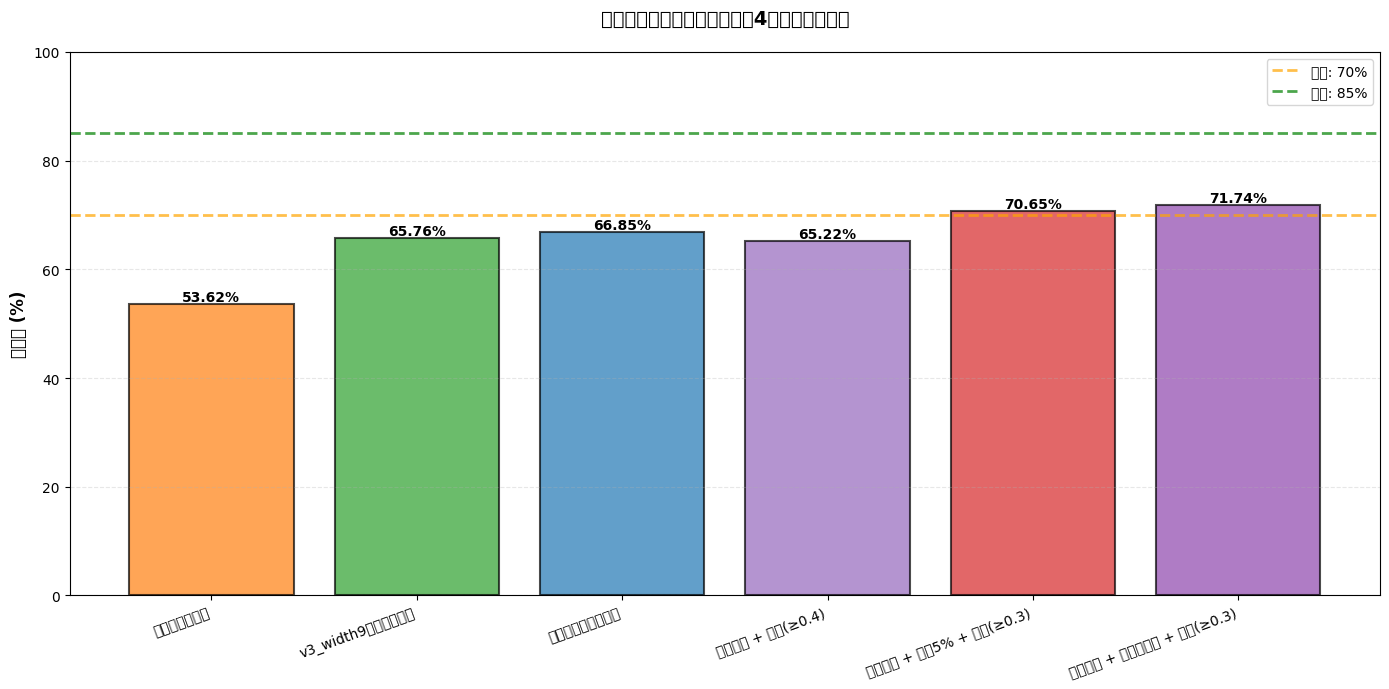


方案 4 改进幅度分析:
----------------------------------------------------------------------
相比原图方案: +18.12%
相比 v3_width9: +5.98%
相比格子分割（未过滤）: +4.89%
相比格子分割+过滤(≥0.4): +6.52%
相比格子分割+裁剪5%+过滤: +1.09%


In [71]:
# 计算方案 4 的准确率
metrics_adaptive = calculate_accuracy(filtered_text_adaptive, gt_clean)

print("="*60)
print("方案 4 - 自适应裁剪策略（早停 + 置信度过滤）")
print("="*60)
print(f"准确率: {metrics_adaptive['accuracy']:.2f}%")
print(f"相似度: {metrics_adaptive['similarity']:.2f}%")
print(f"Ground Truth 长度: {metrics_adaptive['total_chars']}")
print(f"预测文本长度: {len(filtered_text_adaptive)}")
print(f"匹配字符数: {metrics_adaptive['matched_chars']}")
print("="*60)

# 最终所有方案对比
comparison_data_all = {
    '原图（有竖线）': 53.62,
    'v3_width9（删除竖线）': 65.76,
    '格子分割（未过滤）': metrics['accuracy'],
    '格子分割 + 过滤(≥0.4)': metrics_filtered['accuracy'],
    '格子分割 + 裁剪5% + 过滤(≥0.3)': metrics_cropped_filtered['accuracy'],
    '格子分割 + 自适应裁剪 + 过滤(≥0.3)': metrics_adaptive['accuracy']
}

print("\n所有方案最终对比:")
print("-"*70)
for method, acc in comparison_data_all.items():
    print(f"{method:.<50} {acc:.2f}%")
print("="*70)

# 可视化对比
fig, ax = plt.subplots(figsize=(14, 7))
methods = list(comparison_data_all.keys())
accuracies = list(comparison_data_all.values())
colors = ['#ff7f0e', '#2ca02c', '#1f77b4', '#9467bd', '#d62728', '#8e44ad']
bars = ax.bar(methods, accuracies, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)

# 添加数值标签
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}%',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_ylabel('准确率 (%)', fontsize=12, fontweight='bold')
ax.set_title('所有方案准确率对比（含方案4：自适应裁剪）', fontsize=14, fontweight='bold', pad=20)
ax.set_ylim(0, 100)
ax.axhline(y=70, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='目标: 70%')
ax.axhline(y=85, color='green', linestyle='--', linewidth=2, alpha=0.7, label='理想: 85%')
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3, linestyle='--')
plt.xticks(rotation=20, ha='right')
plt.tight_layout()
plt.show()

# 改进幅度分析
print("\n方案 4 改进幅度分析:")
print("-"*70)
print(f"相比原图方案: +{metrics_adaptive['accuracy'] - 53.62:.2f}%")
print(f"相比 v3_width9: +{metrics_adaptive['accuracy'] - 65.76:.2f}%")
print(f"相比格子分割（未过滤）: +{metrics_adaptive['accuracy'] - metrics['accuracy']:.2f}%")
print(f"相比格子分割+过滤(≥0.4): +{metrics_adaptive['accuracy'] - metrics_filtered['accuracy']:.2f}%")
print(f"相比格子分割+裁剪5%+过滤: +{metrics_adaptive['accuracy'] - metrics_cropped_filtered['accuracy']:.2f}%")
print("="*70)


生成方案 4 可视化对比图...


C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\3518806100.py:94: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\3518806100.py:94: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\3518806100.py:94: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\3518806100.py:94: UserWarning: Glyph 20687 (\N{CJK UNIFIED IDEOGRAPH-50CF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\3518806100.py:94: UserWarning: Glyph 35782 (\N{CJK UNIFIED IDEOGRAPH-8BC6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_24308\3518806100.py:94: UserWarning: Gl

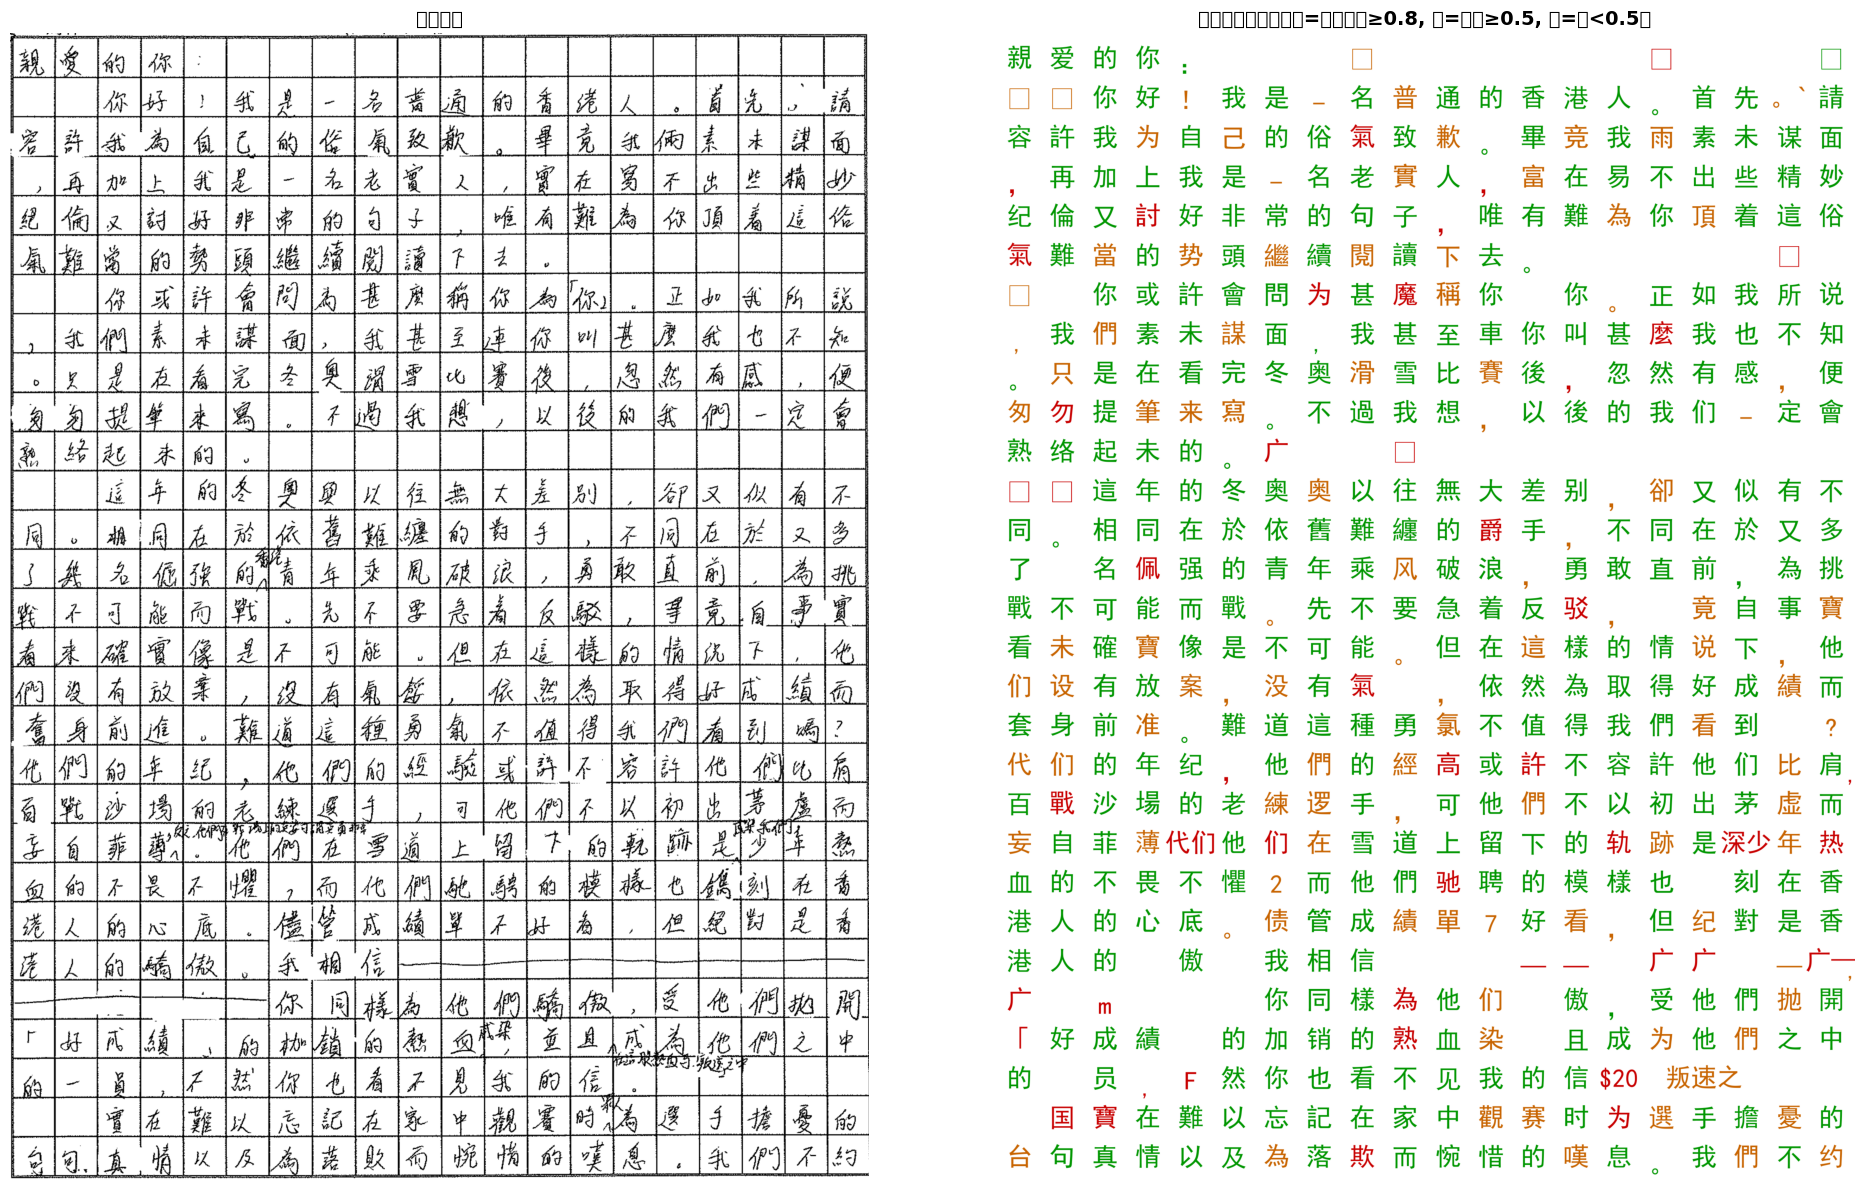

可视化结果已保存到: c:\Users\Quenton\Documents\Github\writtingOCR\output\grid_ocr_adaptive_comparison.png
方案 4 详细结果已保存到: c:\Users\Quenton\Documents\Github\writtingOCR\output\adaptive_cropping_results.json


In [72]:
# 可视化方案 4 的识别结果
print("\n生成方案 4 可视化对比图...")
result_image_adaptive = visualize_ocr_results(img_rgb, filtered_results_adaptive, font_size=65)

# 保存可视化结果
adaptive_vis_path = project_root / 'output' / 'grid_ocr_adaptive_comparison.png'
result_image_adaptive.save(adaptive_vis_path)
print(f"可视化结果已保存到: {adaptive_vis_path}")

# 保存方案 4 的详细结果
adaptive_results_path = project_root / 'output' / 'adaptive_cropping_results.json'
with open(adaptive_results_path, 'w', encoding='utf-8') as f:
    json.dump({
        'strategy': 'adaptive_cropping_with_early_stopping',
        'statistics': stats_adaptive,
        'metrics': metrics_adaptive,
        'total_recognized': len(recognized_text_adaptive),
        'total_filtered': len(filtered_text_adaptive),
        'confidence_threshold': confidence_threshold_final,
        'early_stop_threshold': confidence_threshold_high,
        'results': [
            {
                'row': r['row'],
                'col': r['col'],
                'text': r['text'],
                'confidence': float(r['confidence']),
                'version_used': r['version'],
                'position': r['position']
            }
            for r in recognition_results_adaptive
        ]
    }, f, ensure_ascii=False, indent=2)

print(f"方案 4 详细结果已保存到: {adaptive_results_path}")